In [1]:
# import from different python files 
from circuit_top_tools import *
from analysis_tools import * 
import mdtraj as md 

from cycler import cycler
from matplotlib import colormaps 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns 
import pickle

In [2]:
# set up matplotlib parameters 
plt.rc('font', family='sans-serif', weight='normal', size=14)
plt.rc('axes', linewidth=1.5)

max_num_clusters=5
viridis = colormaps['viridis'].resampled(max_num_clusters)
default_cycler = cycler(color=viridis(range(max_num_clusters)))
# set the visualization style 
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["font.size"]
plt.rcParams.update({"font.size":12, 'ytick.labelsize': '12', 'xtick.labelsize': '12', 'legend.fontsize': '10', 'axes.titlesize': '12'})
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

Trajectory file paths and trajectory loading

In [3]:
# load in the paths of trajectories and initialize global variables
traj_path = "/Users/f006j60/Robustelli_Group/IAPP/wt_714f9/pbc_rerun_3.4us/pbc_1.xtc"
top_path = "/Users/f006j60/git/IAPP/structures/IAPP_714f9_20reps.gro"
traj_dir = "/Users/f006j60/Robustelli_Group/IAPP/cluster_ligands_files/wt_iapp_ligs_out/"
outdir = "./outdir_circuit_top_tinker/"
psystem = "wt_iapp_yxi1"
helixpdb = '/Users/f006j60/git/IAPP/structures/helix_wt.pdb'
prot_len = 38 
stride = 10

In [4]:
def create_combos_map(prot_len):
    """
    create all pair combinations and map to an index 
    """
    combinations = []
    for i in range(prot_len):
        for j in range(i+2, prot_len): 
            combinations.append((i,j))
    combos = np.array(combinations)
    
    map_dict = {}
    for num, k in enumerate(combos):
        map_dict[tuple(k)] = num

    return map_dict

In [5]:
create_combos_map(38)

{(0, 2): 0,
 (0, 3): 1,
 (0, 4): 2,
 (0, 5): 3,
 (0, 6): 4,
 (0, 7): 5,
 (0, 8): 6,
 (0, 9): 7,
 (0, 10): 8,
 (0, 11): 9,
 (0, 12): 10,
 (0, 13): 11,
 (0, 14): 12,
 (0, 15): 13,
 (0, 16): 14,
 (0, 17): 15,
 (0, 18): 16,
 (0, 19): 17,
 (0, 20): 18,
 (0, 21): 19,
 (0, 22): 20,
 (0, 23): 21,
 (0, 24): 22,
 (0, 25): 23,
 (0, 26): 24,
 (0, 27): 25,
 (0, 28): 26,
 (0, 29): 27,
 (0, 30): 28,
 (0, 31): 29,
 (0, 32): 30,
 (0, 33): 31,
 (0, 34): 32,
 (0, 35): 33,
 (0, 36): 34,
 (0, 37): 35,
 (1, 3): 36,
 (1, 4): 37,
 (1, 5): 38,
 (1, 6): 39,
 (1, 7): 40,
 (1, 8): 41,
 (1, 9): 42,
 (1, 10): 43,
 (1, 11): 44,
 (1, 12): 45,
 (1, 13): 46,
 (1, 14): 47,
 (1, 15): 48,
 (1, 16): 49,
 (1, 17): 50,
 (1, 18): 51,
 (1, 19): 52,
 (1, 20): 53,
 (1, 21): 54,
 (1, 22): 55,
 (1, 23): 56,
 (1, 24): 57,
 (1, 25): 58,
 (1, 26): 59,
 (1, 27): 60,
 (1, 28): 61,
 (1, 29): 62,
 (1, 30): 63,
 (1, 31): 64,
 (1, 32): 65,
 (1, 33): 66,
 (1, 34): 67,
 (1, 35): 68,
 (1, 36): 69,
 (1, 37): 70,
 (2, 4): 71,
 (2, 5): 72,
 (2, 

In [6]:
# create an md traj object from the trajectory that you want 
trj = md.load(traj_path, top = top_path, stride=stride)
top = trj.topology
trj

<mdtraj.Trajectory with 4301 frames, 598 atoms, 39 residues, and unitcells at 0x16937c6d0>

In [7]:
trj.n_residues

39

Now, we can compute everything we need for analysis that will be carried out later on the clusters that are identified. 

In [8]:
h_res = []
for res in trj.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 0
hres_renum = np.asarray(h_res)+residue_offset
print(hres_renum)
dssp_all = md.compute_dssp(trj, simplified=True)
dssp_all_array = np.array(dssp_all)
dssp_all_H, dssp_all_E = dssp_convert(dssp_all)

helixBB = md.load_pdb(helixpdb)
Sa_total = calc_Sa(trj, helixBB)
rg_CA = calc_rg(trj)

# generate the contact map of the whole trajectory 
contact_map, distance_map = contact_map_avg(trj, prot_len-1)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [9]:
dsspH = np.copy(dssp_all)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
print(TotalH)

[23 18 23 ...  7 10  0]


In [10]:
# # save this 
# np.save(outdir+psystem+"_Rg_total" + ".npy", rg_CA)
# np.save(outdir+psystem+"_Sa_total" + ".npy", Sa_total)
# np.save(outdir+psystem+"_H_total" + ".npy", TotalH)

Define the cutoff distances that you'd like for the analysis

In [11]:
# Format
fileformat = 'pdb'

# cutoff_distance, maximal distance (Ångström) between two atoms that will count as an atom-atom contact.
# cutoff_numcontacts, minimum number of contacts between two residues to count as a res-res contact.
# exclude_neighbour, number of neighbours that are excluded from possbile res-res contacts.

# CT variables
cutoff_distance =       10
cutoff_numcontacts =    1 # any contact counts as a contact
exclude_neighbour =     1

# there might be more functionality to add 
# #Length Filtering
# length_filtering =      0
# filtering_distance =    0
# length_mode =           '<'

# #Energy filtering
# energy_filtering =      0
# energy_filtering_mode = '+'

# # Exporting
# plot_figures =          1
# exporting_psc =         0
# exporting_cmap3 =       0
# exporting_mat   =       0

In [12]:
# os.remove(outdir + psystem + ".npy")

In [13]:
# circuit_matrix, circuit_model, map_dict = compute_circuit_top_model(trj, cutoff_distance=cutoff_distance, cutoff_numcontacts=cutoff_numcontacts, exclude_neighbour=exclude_neighbour)
# # save the circuit_model as a .npy file 
# np.save(outdir + psystem + ".npy", circuit_model, allow_pickle=False, fix_imports=False)
# np.save(outdir + psystem + "matrix.npy", circuit_matrix, allow_pickle=False, fix_imports=False)

In [14]:
# circuit_model = np.load(outdir+psystem+".npy")
circuit_matrix = np.load(outdir+psystem+"matrix.npy")

In [15]:
# scaler = MinMaxScaler()
# scaler.fit(circuit_model)
# scaled_model = scaler.transform(circuit_model)

# pca = PCA(n_components=2)
# pca.fit(scaled_model)
# # scaling the model to see if that changes things! 
# reduced = pca.fit_transform(scaled_model)
# PC1 = reduced[:, 0]
# PC2 = reduced[:, 1]

In [16]:
# # # save the PCs
# np.save(outdir+psystem+"PCs.npy", reduced, allow_pickle=False, fix_imports=False)

In [17]:
reduced = np.load(outdir+psystem+"PCs.npy")
PC1 = reduced[:, 0]
PC2 = reduced[:, 1]

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_34104/1480363946.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cdict = cm.get_cmap("nipy_spectral")._segmentdata


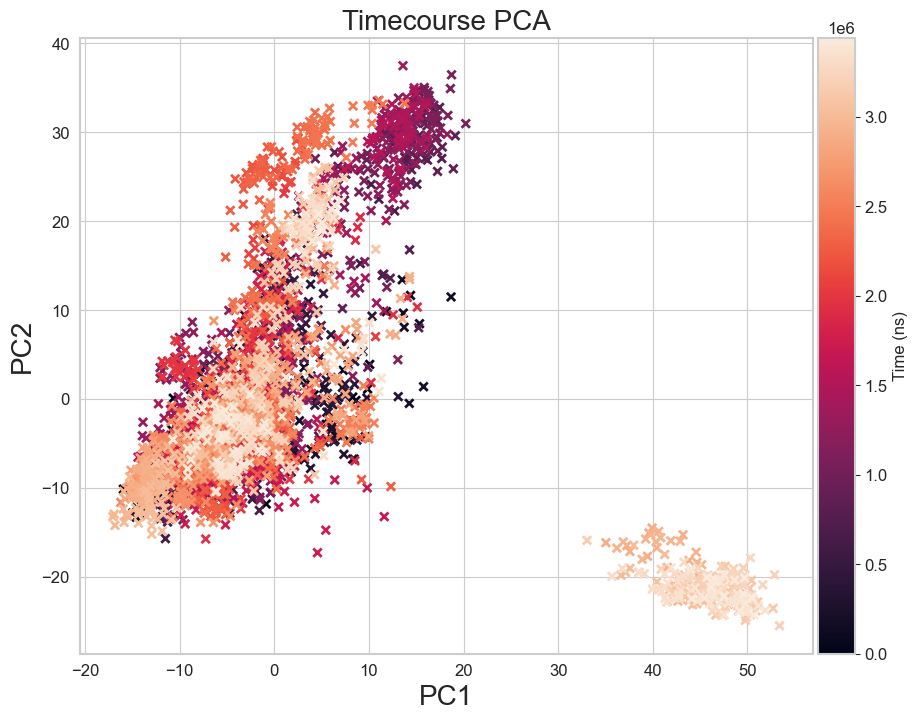

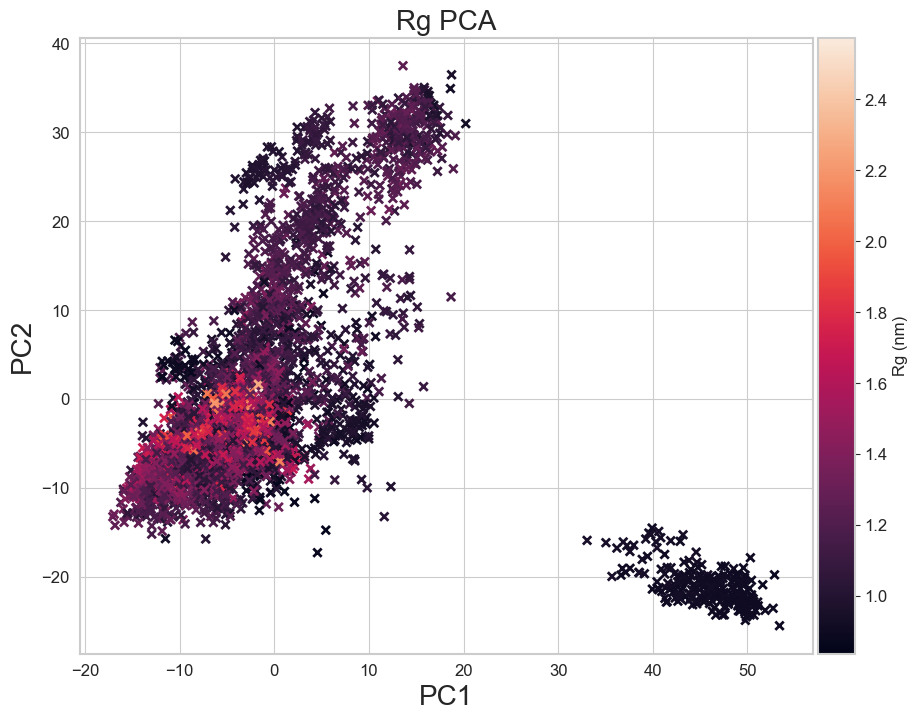

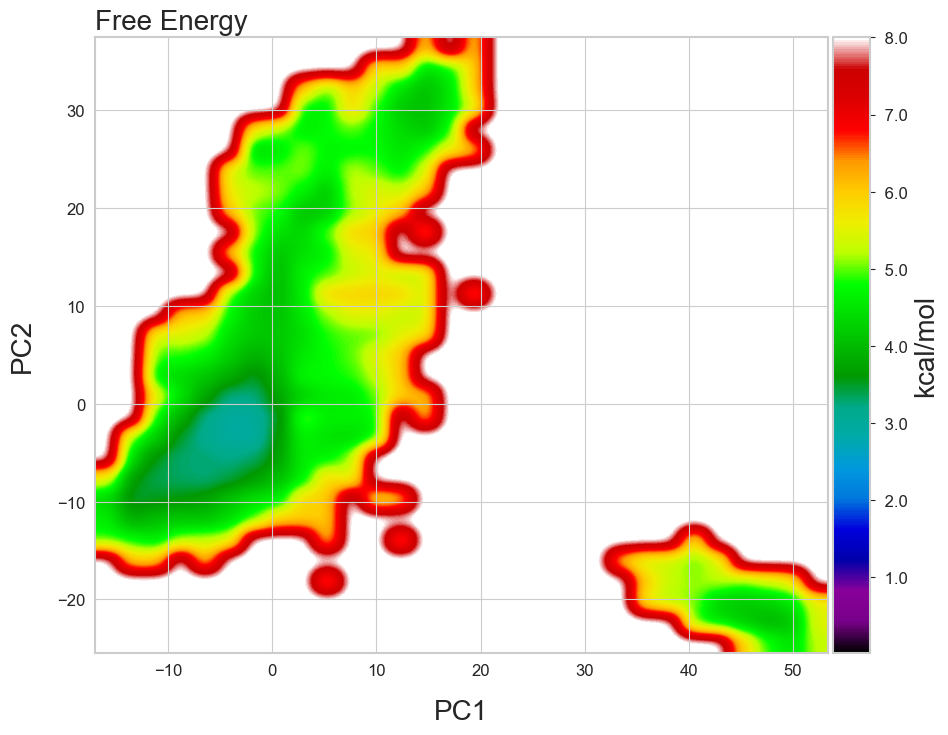

In [18]:
# make a new color map 
cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)
ax1 = plt_project_time(PC1, PC2, trj.n_frames, time=trj.time[-1])
ax2 = plt_project_rg(PC1, PC2, trj)
ax3 = plt_free_energy(PC1, PC2, col_map= n_cmap, title="Free Energy" ) 


Here we can try different clusters and evaluate, which number of clusters is best

KMeans clustering analysis for wt_iapp_yxi1
__________________________________________________________________________________
n_cluster	silhouette score	Inertia
2	 	 0.741359		706096.8871157786
3	 	 0.671790		230873.88903535315


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416:

4	 	 0.440466		152089.92166434997
5	 	 0.448140		109539.76973013362


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


6	 	 0.424351		90509.41968047987
7	 	 0.395293		76463.52440730999


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8	 	 0.401541		64896.34961485831
9	 	 0.385773		57258.269162683704


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


10	 	 0.387941		51476.60073695032
11	 	 0.379007		46896.858617460064
12	 	 0.395558		43280.20609542499


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


13	 	 0.392266		39896.34271239022
14	 	 0.388563		36904.22960340315


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


15	 	 0.372930		34146.55083747722
16	 	 0.368089		32212.217347571885


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


17	 	 0.359085		29949.309459808926
18	 	 0.365518		28524.44967611222


/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


19	 	 0.358322		26807.907443599215
__________________________________________________________________________________


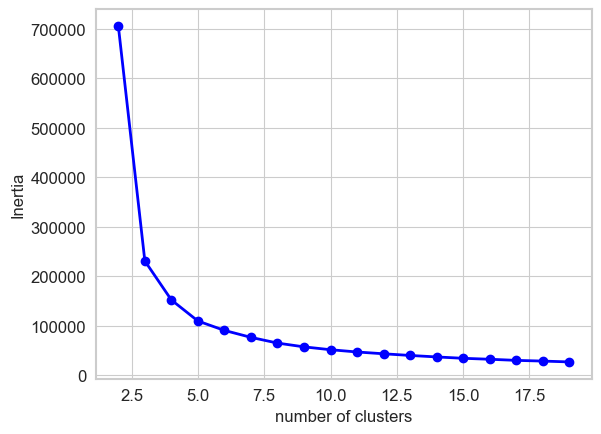

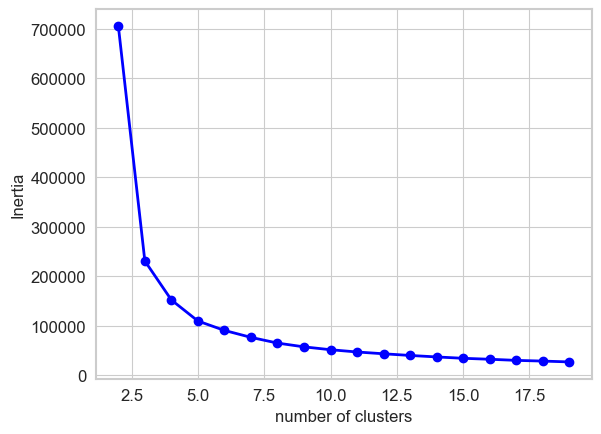

In [19]:
# clusters between 2 and 15, but could define otherwise
# benchmark kmeans 
data = np.column_stack((PC1,PC2), )
bench_k_means(psystem, data, clusters = np.arange(2,20,1))

/Users/f006j60/miniconda3/envs/labconda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


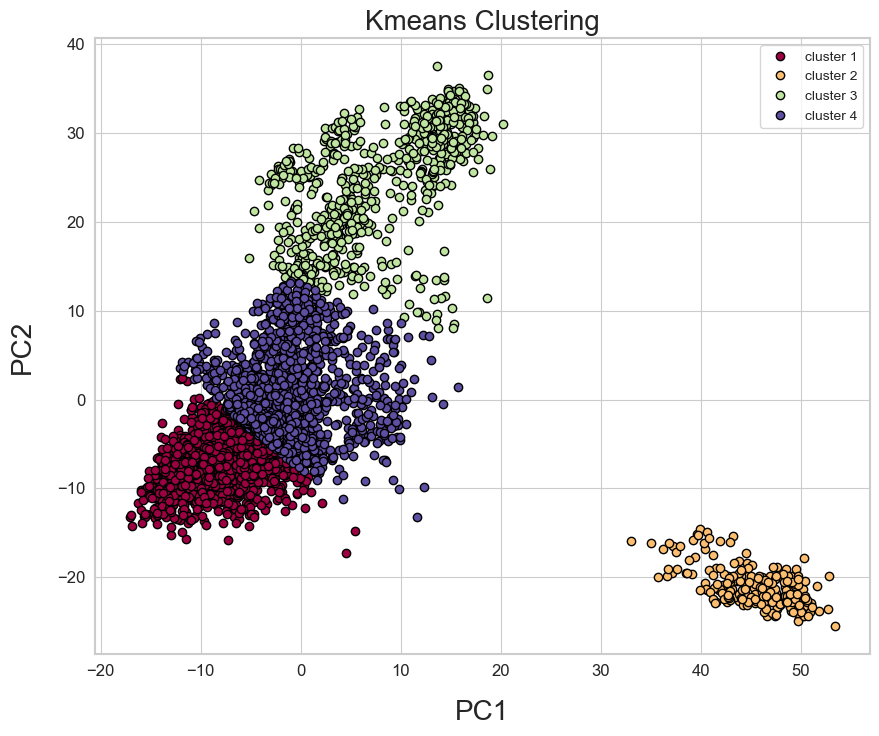

In [20]:
n_cluster=4
ax, kmean_labels, centers = kmeans_cluster(PC1, PC2, clusters=n_cluster, title = "Kmeans Clustering")

Now we can assign those clusters and do further plotting/analyses

In [21]:
# # create a c_dict for each cluster  
# c_dict = {}
# for i in range(n_cluster):
#     ind = np.where(kmean_labels==i)[0]
#     c_dict[i] = np.array(ind)

# c_dict_reorder = {}
# # reorder clusters by % helix, largest to smallest
# order = np.argsort([np.average(TotalH[c_dict[c]]) for c in range(n_cluster)])[::-1]
# for c in range(n_cluster): 
#     c_dict_reorder[c] = c_dict[order[c]]

# # define the reordered element
# c_dict = c_dict_reorder

# # save this dictionary, so that the overall stats can be saved, while still being able to index the clusters 
# import pickle 

# with open(outdir+psystem+"_kmeans_cluster_indices.pkl", "wb") as f: 
#     pickle.dump(c_dict, f)

In [22]:
with open(outdir+psystem+"_kmeans_cluster_indices.pkl", "rb") as f: 
    c_dict = pickle.load(f)

(array([0.000, 1.000, 2.500]),
 [Text(1, 0.0, ' 0.0'), Text(1, 1.0, ' 1.0'), Text(1, 2.5, ' 2.5')])

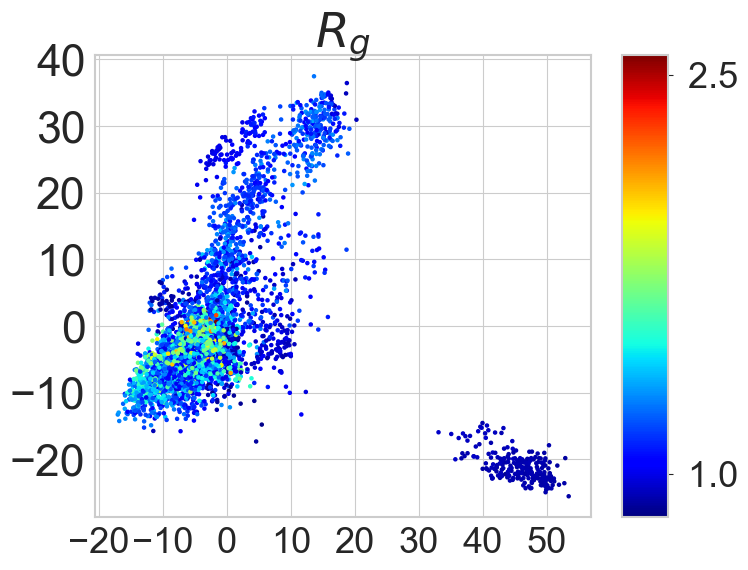

In [23]:
fig = plt.figure(figsize=(8, 6))
im = plt.scatter(PC1,PC2,c=rg_CA,s=5, cmap='jet')
#plt.imshow(a, interpolation='gaussian', extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2.5]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
#plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.title(r'$R_g$', size=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
#plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

(array([ 0,  5, 10, 20, 25]),
 [Text(1, 0, ' 0.0'),
  Text(1, 5, ' 5.0'),
  Text(1, 10, ' 10.0'),
  Text(1, 20, ' 20.0'),
  Text(1, 25, ' 25.0')])

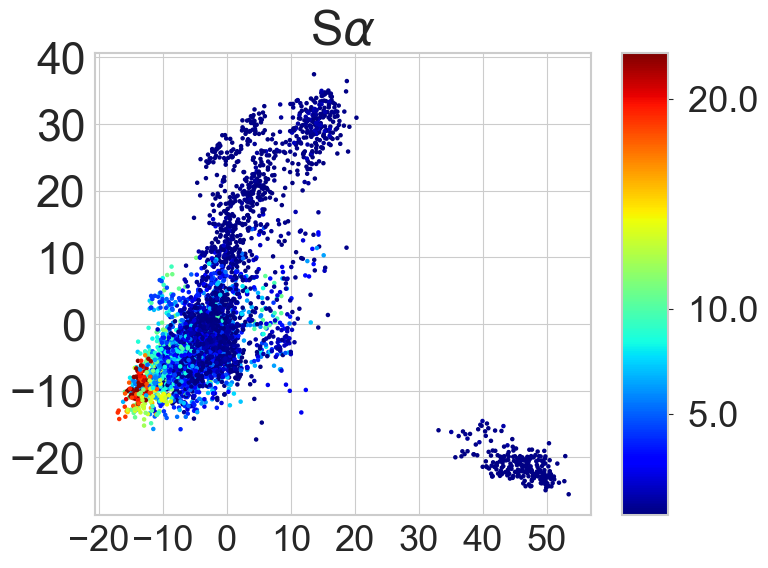

In [24]:
fig = plt.figure(figsize=(8, 6))
im = plt.scatter(PC1,PC2,c=Sa_total,s=5, cmap='jet')
#plt.imshow(a, interpolation='gaussian', extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 5, 10, 20, 25]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
#plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.title(r'S$\alpha$', size=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
#plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

(array([ 0, 10, 20, 30, 40]),
 [Text(1, 0, ' 0.0'),
  Text(1, 10, ' 10.0'),
  Text(1, 20, ' 20.0'),
  Text(1, 30, ' 30.0'),
  Text(1, 40, ' 40.0')])

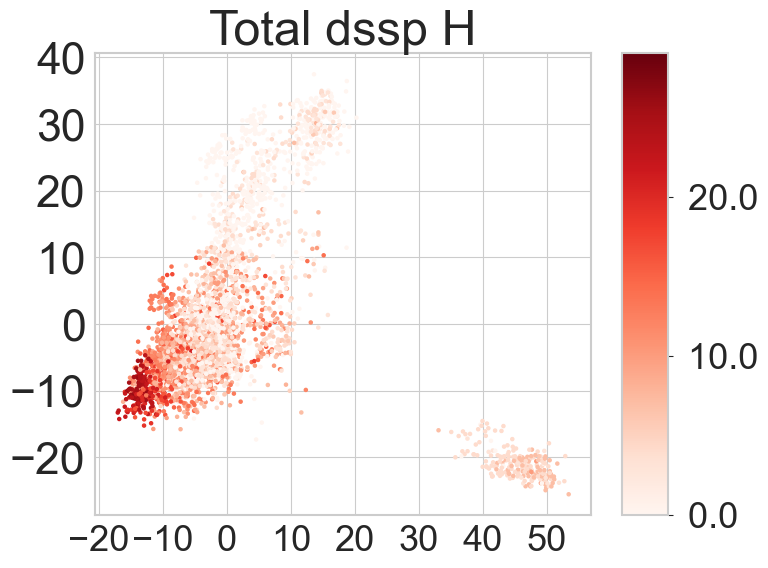

In [25]:
fig = plt.figure(figsize=(8, 6))
im = plt.scatter(PC1, PC2, c=TotalH ,s=5, cmap='Reds')
#plt.imshow(a, interpolation='gaussian', extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,10,20,30,40]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.title("Total dssp H", size=35)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.yticks(size='26')

/Users/f006j60/git/IAPP/analysis/IAPP_circuit_top/analysis_tools.py:114: RuntimeWarning: invalid value encountered in divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


([<matplotlib.axis.XTick at 0x1696ca6a0>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(9, 0, '9'),
  Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15'),
  Text(17, 0, '17'),
  Text(19, 0, '19'),
  Text(21, 0, '21'),
  Text(23, 0, '23'),
  Text(25, 0, '25'),
  Text(27, 0, '27'),
  Text(29, 0, '29'),
  Text(31, 0, '31'),
  Text(33, 0, '33'),
  Text(35, 0, '35'),
  Text(37, 0, '37')])

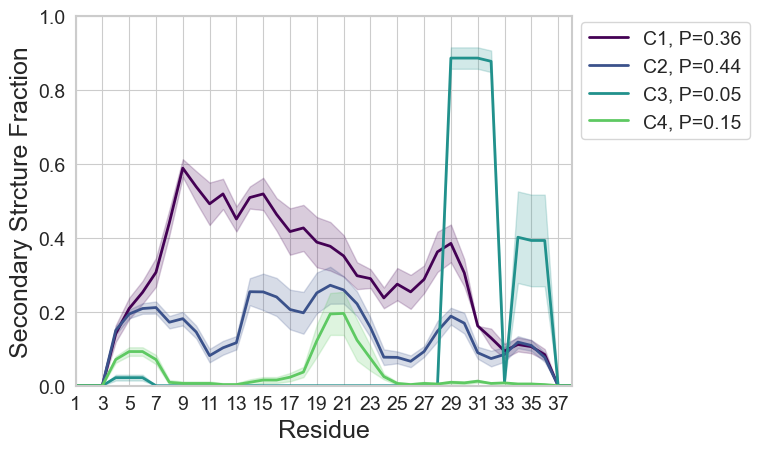

In [26]:
for i in range(0, n_cluster):
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[i]])
    plt.plot(hres_renum, H1_H[:, 0], label='C%s' %
             str(i+1) + ", P=" + str(np.round(len(c_dict[i])/trj.n_frames, 2)), color="C" + str(i))
    plt.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color="C" + str(i))
plt.ylim(0, 1.0)
plt.xlim(1,38)
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01), fontsize=14, ncol=1)
plt.xticks(np.arange(1,38,2))

In [27]:
hres_renum

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])

In [28]:
np.save(outdir + psystem + "_secondary_structure_str" + ".npy", dssp_all)

In [29]:
contact_maps = []
distance_maps = []
# trjs = []
for t in set(kmean_labels): 
    temptrj = trj.slice(np.where(kmean_labels == t)[0])
    print(temptrj.n_frames)
    # trjs.append(trj)
    # contact map 
    final_map, final_distance = contact_map_avg(temptrj, prot_len-1)
    contact_maps.append(final_map)
    distance_maps.append(final_distance)

1532
229
649
1891


In [30]:
sequence_ol = []
for i in range(0, prot_len - 1):
    sequence_ol.append(str(trj.topology.residue(i).code))
# add the cap 
sequence_ol.append("   NH2")
print(sequence_ol)

['K', 'C', 'N', 'T', 'A', 'T', 'C', 'A', 'T', 'Q', 'R', 'L', 'A', 'N', 'F', 'L', 'V', 'H', 'S', 'S', 'N', 'N', 'F', 'G', 'A', 'I', 'L', 'S', 'S', 'T', 'N', 'V', 'G', 'S', 'N', 'T', 'Y', '   NH2']


In [31]:
trj = md.load(traj_path, top = top_path, stride=stride)
top = trj.topology
trj

<mdtraj.Trajectory with 4301 frames, 598 atoms, 39 residues, and unitcells at 0x16a5c4910>

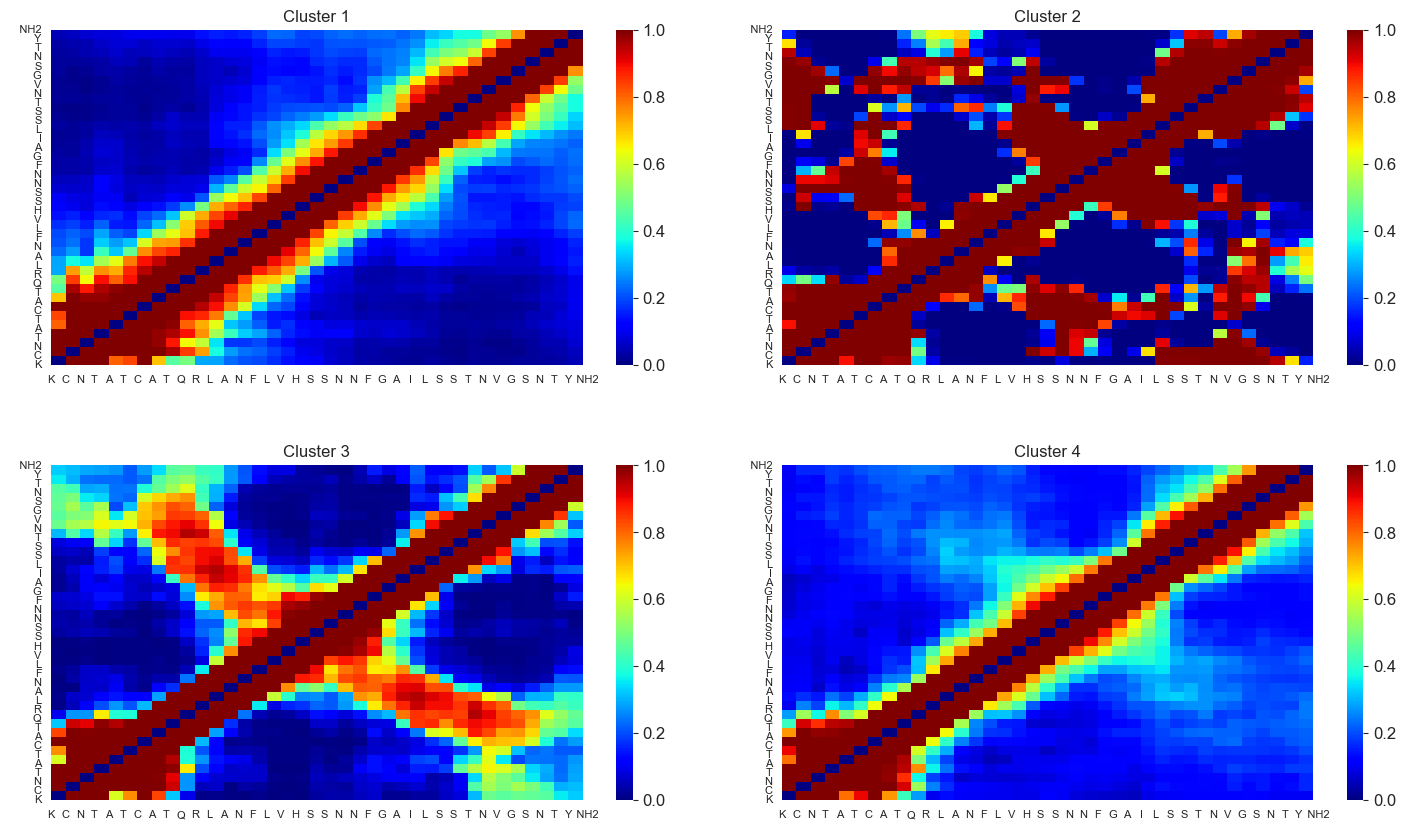

In [32]:
import seaborn as sns 
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Loop through the axes and images to populate the subplots
for i, (ax, c_map) in enumerate(zip(axes.flat, contact_maps)):
    im = sns.heatmap(c_map, cmap='jet', ax=ax)
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0,38), sequence_ol, rotation=0, size=8)
    ax.set_yticks(range(0,38), sequence_ol, rotation=0, size=8)
    ax.invert_yaxis()
    
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1}', fontsize=12)  # Customize title as needed

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increased vertical spacing

# Show the plot
plt.show()

In [33]:
def make_dual_map(trj, prot_len=38, ligand_idx = 38):
    contact_maps = []
    for i in range(0, prot_len):
        # print(i)
        contact_map = []
        for j in range(0, prot_len):
            dist1 = md.compute_contacts(trj, [[i, ligand_idx]], scheme='closest-heavy')
            dist2 = md.compute_contacts(trj, [[j, ligand_idx]], scheme='closest-heavy')
            array1 = np.asarray(dist1[0]).astype(float)
            array2 = np.asarray(dist2[0]).astype(float)
            contact1 = np.where(array1 < 0.5, 1, 0)
            contact2 = np.where(array2 < 0.5, 1, 0)
            sum = contact1 + contact2
            contact = np.where(sum == 2, 1, 0)
            contacts = np.average(contact)
            contact_map.append(contacts)
        contact_maps.append(contact_map)
    final_map = np.asarray(contact_maps).astype(float)
    return final_map

In [34]:
dual_contact_maps = []
for t in set(kmean_labels): 
    temptrj = trj.slice(np.where(kmean_labels == t)[0])
    # dual contact map 
    dual_contact_map = make_dual_map(temptrj, prot_len-1)
    dual_contact_maps.append(dual_contact_map)

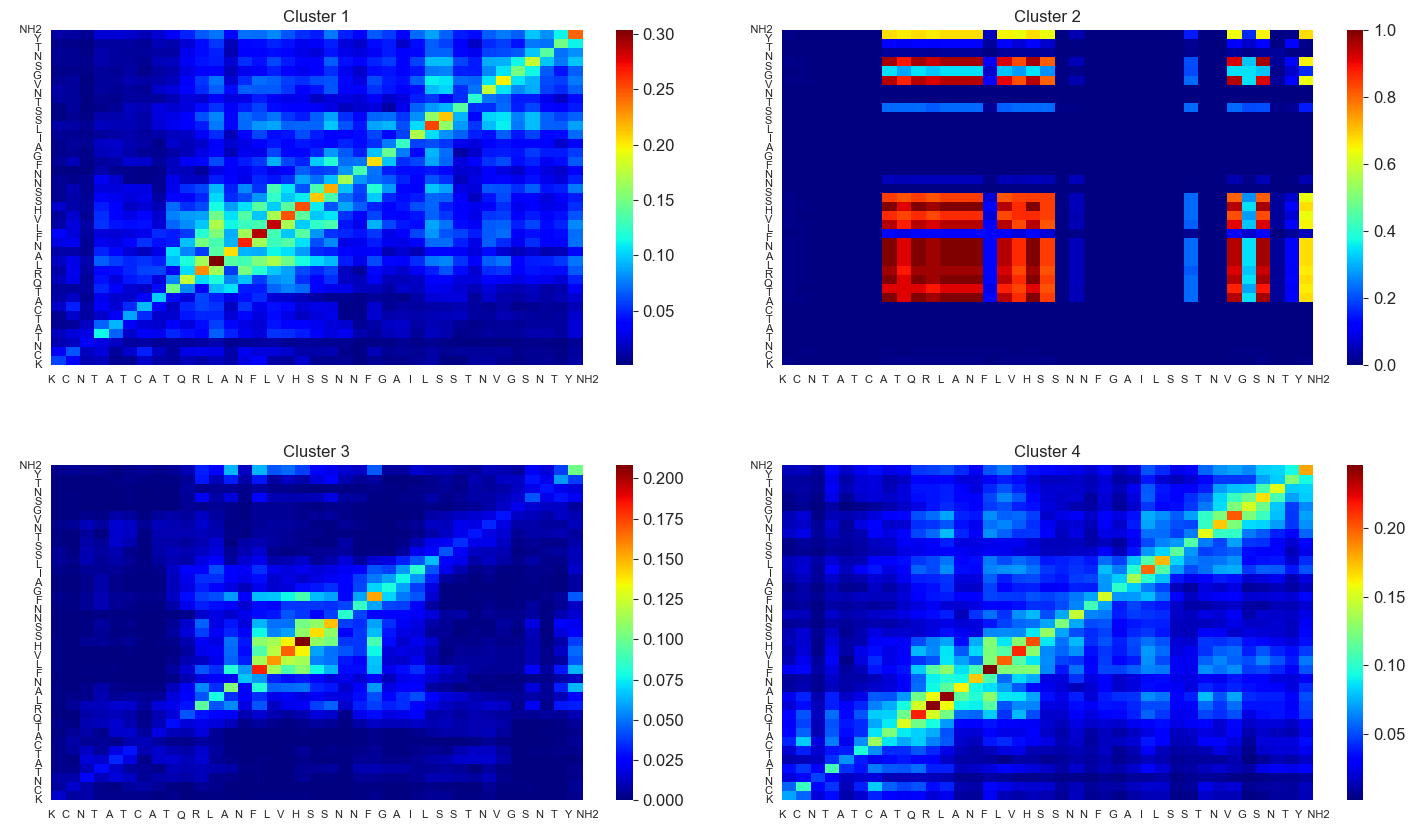

In [35]:
import seaborn as sns 
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Loop through the axes and images to populate the subplots
for i, (ax, d_map) in enumerate(zip(axes.flat, dual_contact_maps)):
    im = sns.heatmap(d_map, cmap='jet', ax=ax)
    ax.grid(which='both', alpha=0.5)
    ax.set_xticks(range(0,38), sequence_ol, rotation=0, size=8)
    ax.set_yticks(range(0,38), sequence_ol, rotation=0, size=8)
    ax.invert_yaxis()
    
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1}', fontsize=12)  # Customize title as needed

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increased vertical spacing

# Show the plot
plt.show()

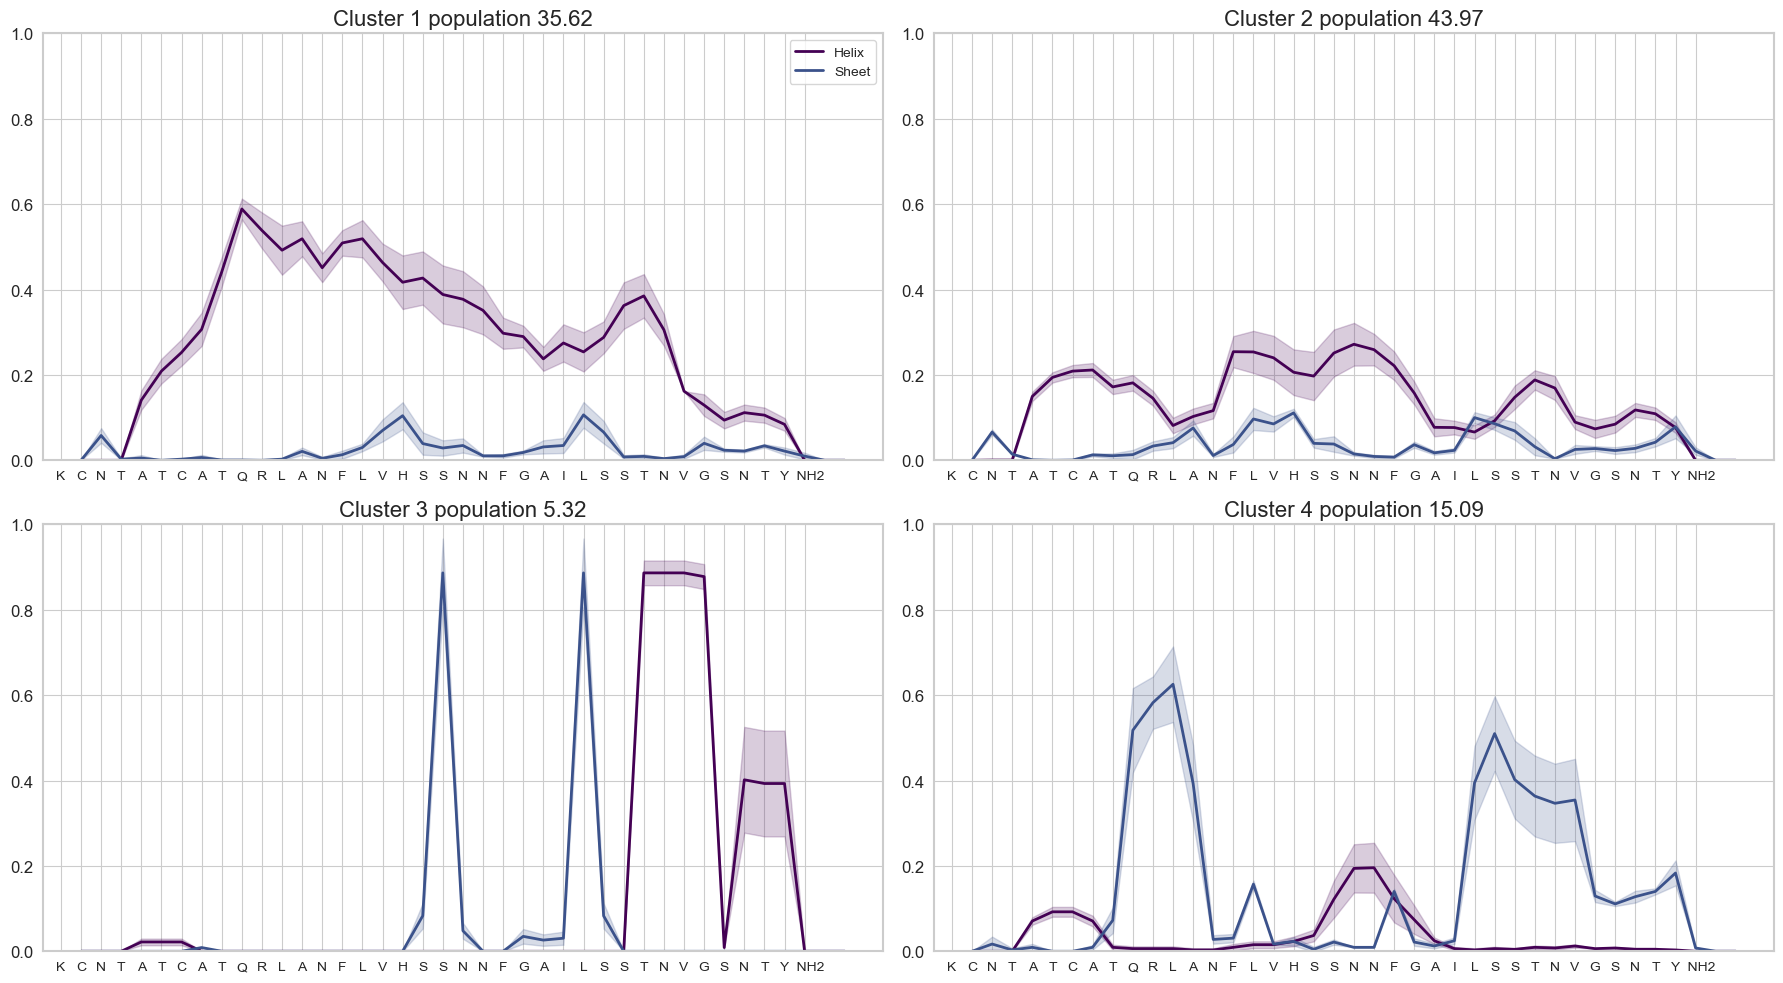

In [36]:
num_rows = 2
num_cols = 2

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

# Loop through the axes and images to populate the subplots
for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[i]])

    ax.plot(hres_renum, H1_H[:, 0], label='Helix', color="C0")
    ax.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color="C0")
    
    ax.plot(hres_renum, H1_E[:, 0], label='Sheet', color="C1")
    ax.fill_between(hres_renum, H1_E[:, 0]-H1_E[:, 1],
                     H1_E[:, 0]+H1_E[:, 1], alpha=0.2, color="C1")
    
    ax.set_xticks(range(38), sequence_ol, fontsize=10)
    ax.set_ylim(0,1.0)
    # Add a title to the subplot
    ax.set_title(f'Cluster {i+1} population ' + str(np.round((c_dict[i].size/trj.n_frames * 100), decimals=2)), fontsize=16)  # Customize title as needed

# add legend only to last cluster
axes[0,0].legend(loc = "upper right")
# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Increased vertical spacing
plt.tight_layout()
# Show the plot
plt.show()

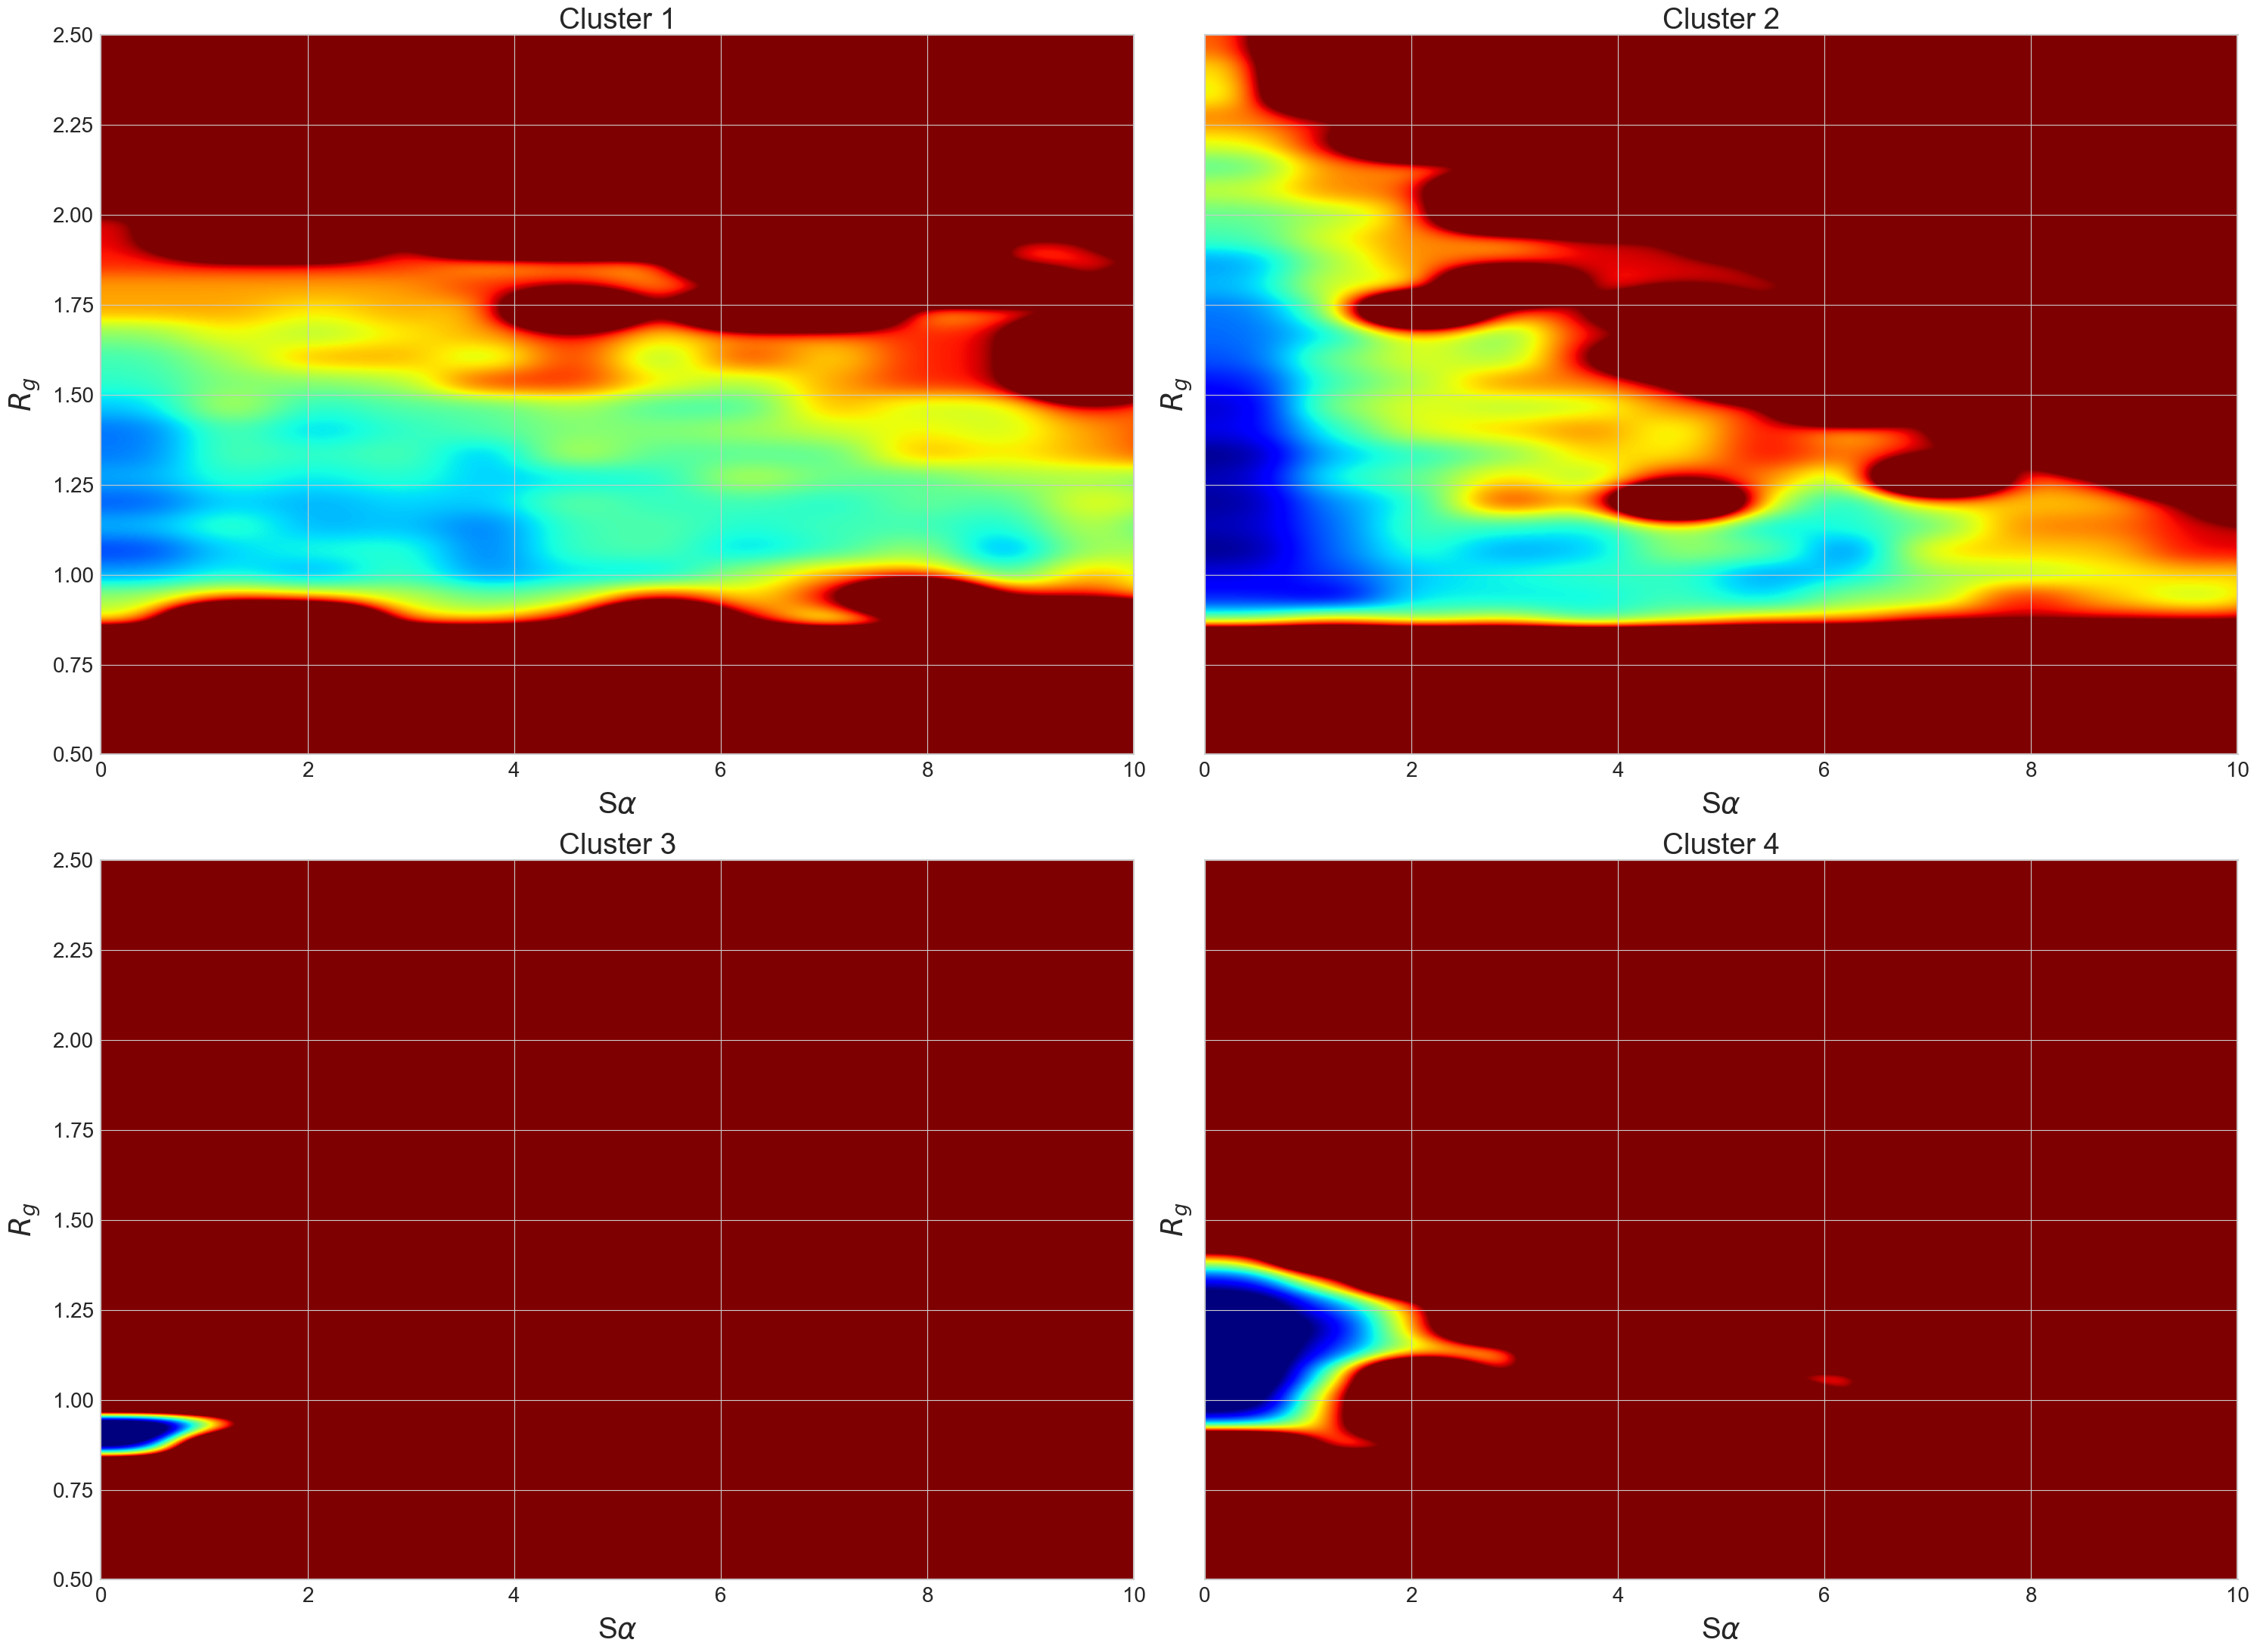

In [37]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 22), sharey=True)

for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    
    frame_ind = c_dict[i]

    a, xedges, yedges = np.histogram2d(rg_CA[frame_ind], Sa_total[frame_ind], 30, [
        [0.5, 2.5], [0, 25.0]], density=True, weights=None)
    a = np.log(np.flipud(a)+.000001)
    T = 300
    a = -(0.001987*T)*a

    im = ax.imshow(a, interpolation='gaussian', extent=[
        yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
    im.set_clim(0.1, 3)
    ax.set_xlim(0, 10)
    ax.set_ylim(0.5,2.5)
    ax.set_ylabel("$R_g$", size=28, labelpad=10)
    ax.set_xlabel(r'S$\alpha$', size=28, labelpad=10)
    ax.set_title('Cluster %s' % str(i+1), size=28)
    ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()

Show the image created using the plots below. I will be creating an 

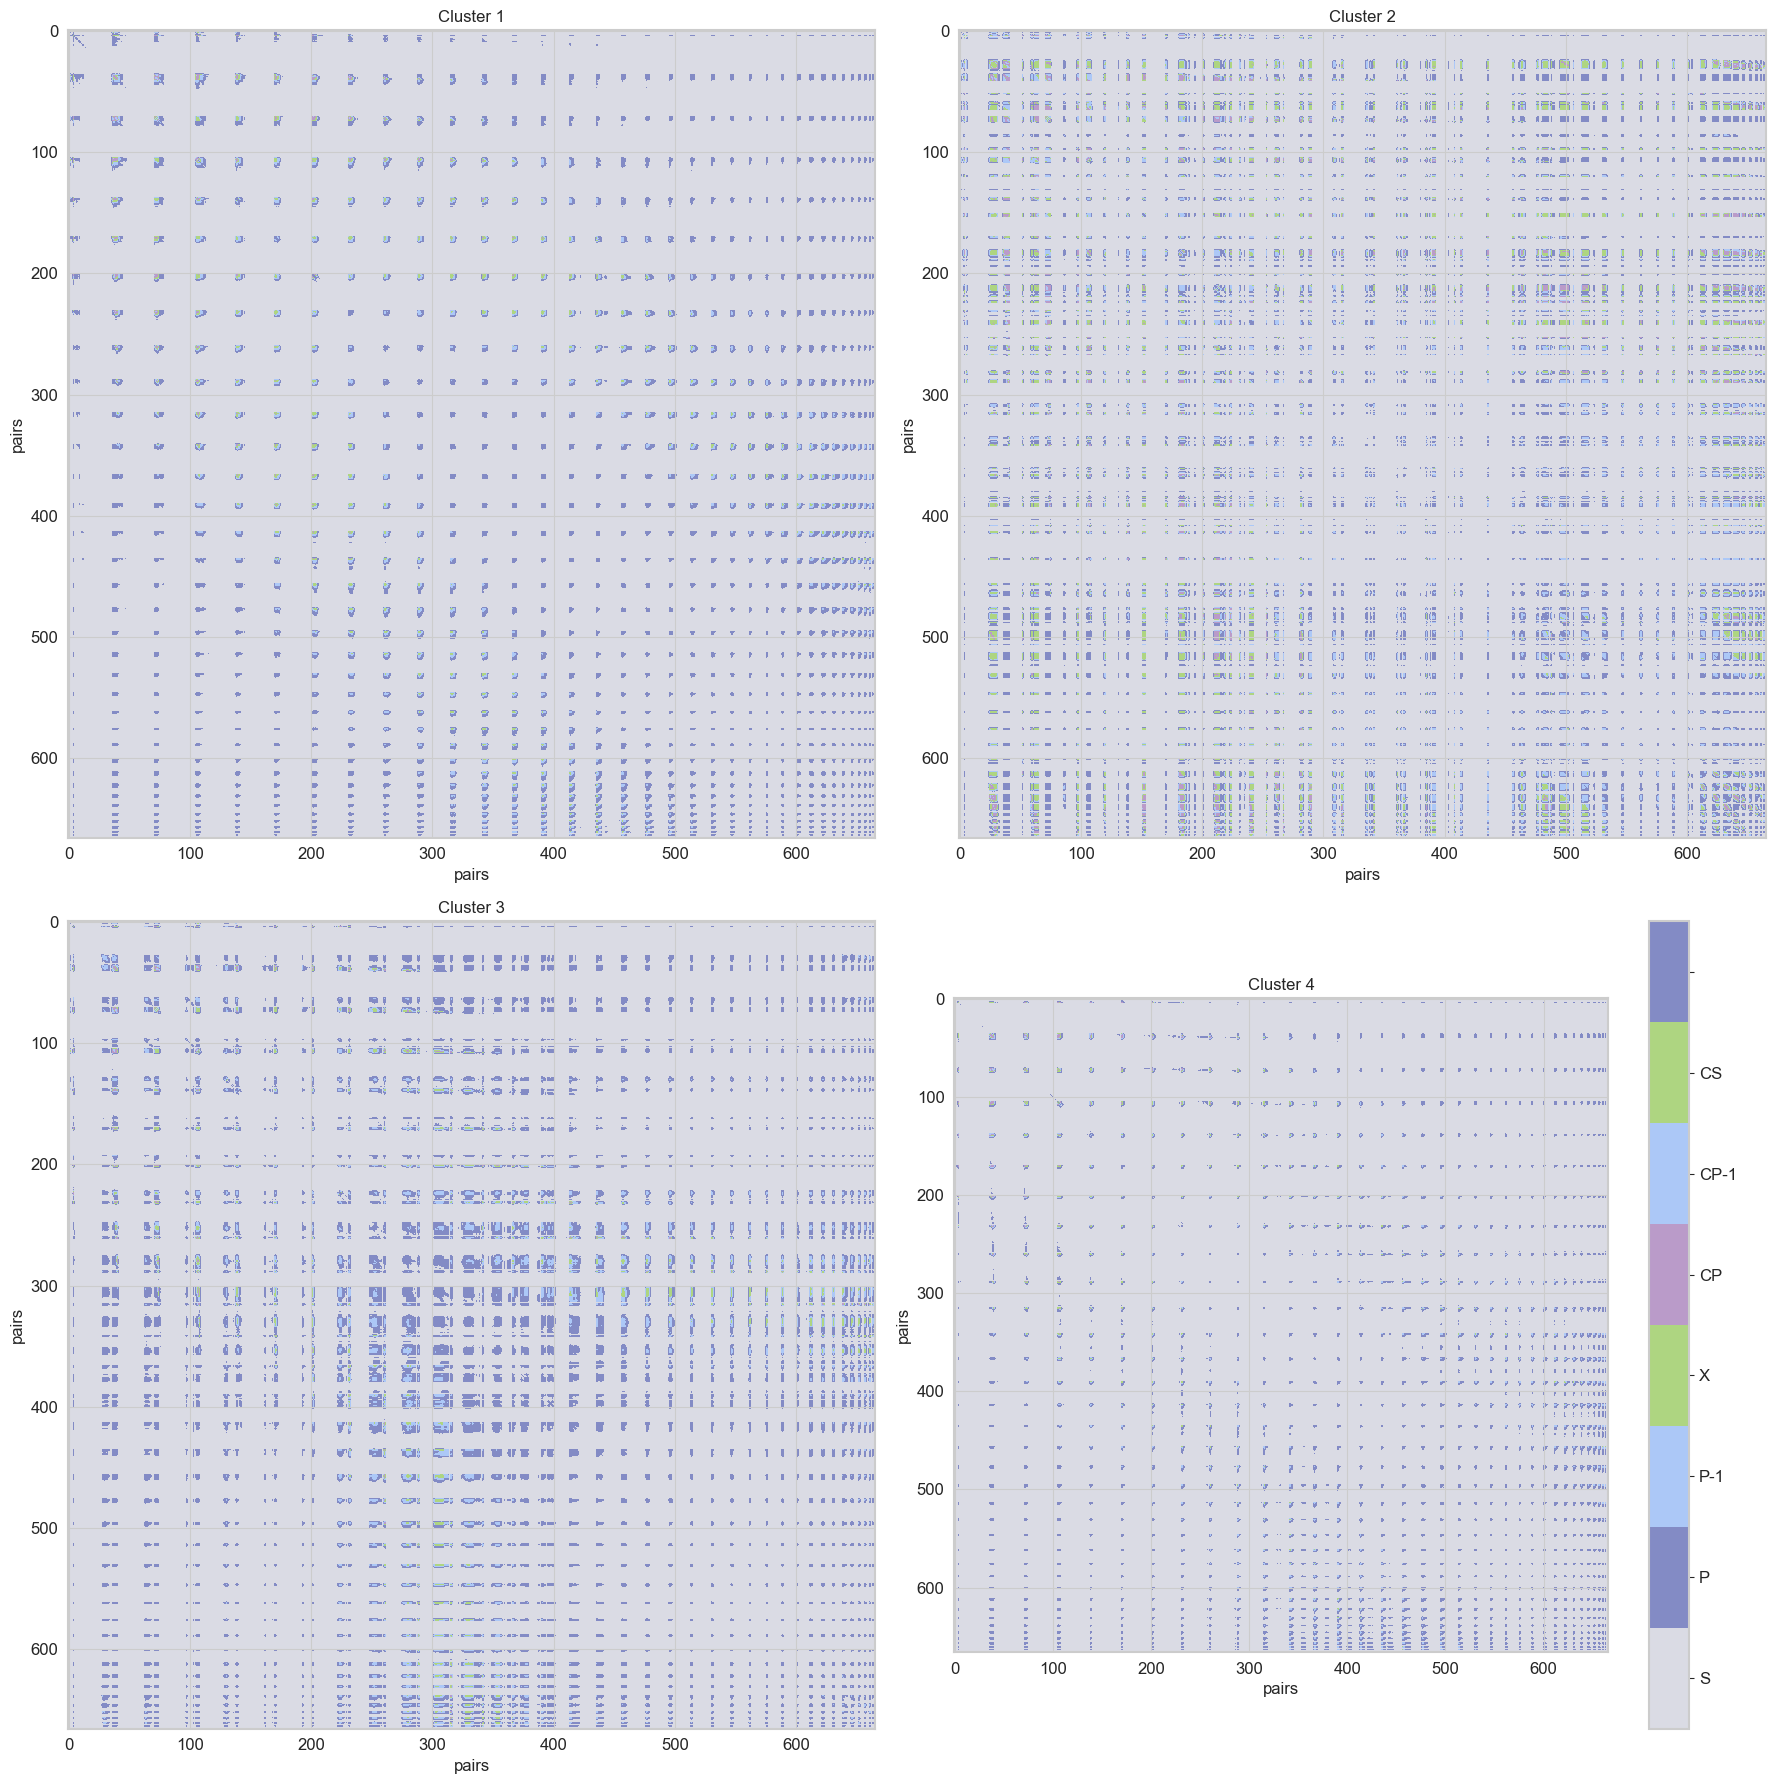

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#create custom colormap
newcolors = np.array([[218/255, 219/255, 228/255,1], #grey - 
                    [131/255, 139/255, 197/255,1],    #purple S
                    [172/255,200/255,247/255,1],       #blue P
                    [174/255,213/255,129/255,1],         #mint green P-1
                    [186/255, 155/255, 201/255,1],        #red purple - X
                    [172/255, 200/255, 247/255,1],        #blue P
                    [174/255, 213/255, 129/255,1],        #mint green
                    [131/255,139/255, 197/255,1]])        #purple S
newcmp = ListedColormap(newcolors)
color = plt.get_cmap(newcmp, 8)

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))

# Loop through the axes and images to populate the subplots
for i, ax in enumerate(axes.flat):
    if i > n_cluster-1: 
        break
    data = circuit_matrix[np.where(kmean_labels == i)]
    data = np.average(data, axis=0)

    im = ax.imshow(data, cmap = color, vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    ax.set_title(f'Cluster {i+1}', fontsize=12) 
    ax.set_xlabel("pairs")
    ax.set_ylabel("pairs")

    # make the values symmetric 
    for i in range(data.shape[0]): 
        for j in range(i, data.shape[0]): 
            data[j,i] = data[i,j]

# figure out the colorbar 
cbar = fig.colorbar(im)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cbar.ax.set_yticklabels(['-','S','P','P-1','X','CP','CP-1','CS']) 
plt.tight_layout()

In [39]:
def calc_contact(trj, ligand_residue_index):
    residues = 38
    contact_pairs = np.zeros((residues, 2))

    for i in range(0, residues):
        contact_pairs[i] = [i, ligand_residue_index]
    contact = md.compute_contacts(trj, contact_pairs, scheme='closest-heavy')
    contacts = np.asarray(contact[0]).astype(float)
    cutoff = 0.6
    contact_matrix = np.where(contacts < cutoff, 1, 0)

    return contact_matrix

def calc_hphob(trj, ligand_residue_index, residues=38):
    top = trj.topology 
    n_frames = trj.n_frames
    residues = residues
    ligand_hphob = top.select("resid %s and element C" % str(ligand_residue_index))
    protein_hphob = top.select("protein and element C")
    
    hphob_pairs = []
    for i in ligand_hphob:
        for j in protein_hphob:
            hphob_pairs.append([i, j])

    contact = md.compute_distances(trj, hphob_pairs)
    contacts = np.asarray(contact).astype(float)
    cutoff = 0.4
    contact_frames = np.where(contacts < cutoff, 1, 0)
    contact_prob_hphob = np.sum(contact_frames, axis=0)/trj.n_frames

    Hphob_res_contacts = np.zeros((n_frames, residues))
    for frame in range(n_frames):
        if np.sum(contact_frames[frame]) > 0:
            contact_pairs = np.where(contact_frames[frame] == 1)
            for j in contact_pairs[0]:
                residue = top.atom(hphob_pairs[j][1]).residue.resSeq
                Hphob_res_contacts[frame][residue-1] = 1

    return Hphob_res_contacts

def calc_aromatic(trj, ligand_rings, residues=38):
    n_frames = trj.n_frames
    top = trj.topology
    n_rings = len(ligand_rings)
    residues = residues
    residue_offset = 0
    
    ligand_ring_params = []
    for i in range(0, n_rings):
        ring = np.array(ligand_rings[i])
        positions = trj.xyz[:, ring, :]
        ligand_centers_normals = get_ring_center_normal_trj_assign_atomid(
            positions, 0, 1, 2)
        ligand_ring_params.append(ligand_centers_normals)

    prot_rings = []
    aro_residues = []
    prot_ring_name = []
    prot_ring_index = []

    aro_select = top.select("resname TYR PHE HIS TRP and name CA")
    for i in aro_select:
        atom = top.atom(i)
        resname = atom.residue.name
        if resname == "TYR":
            ring = top.select(
                "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        if resname == "TRP":
            ring = top.select(
                "resid %s and name CG CD1 NE1 CE2 CD2 CZ2 CE3 CZ3 CH2" % atom.residue.index)
        if resname == "HIS":
            ring = top.select("resid %s and name CG ND1 CE1 NE2 CD2" %
                            atom.residue.index)
        if resname == "PHE":
            ring = top.select(
                "resid %s and name CG CD1 CD2 CE1 CE2 CZ" % atom.residue.index)
        prot_rings.append(ring)
        prot_ring_name.append(atom.residue)
        prot_ring_index.append(atom.residue.index+residue_offset)

    prot_ring_params = []
    for i in range(0, len(prot_rings)):
        ring = np.array(prot_rings[i])
        positions = trj.xyz[:, ring, :]
        ring_centers_normals = get_ring_center_normal_trj_assign_atomid(
            positions, 0, 1, 2)
        prot_ring_params.append(ring_centers_normals)
        
    frames = n_frames
    sidechains = len(prot_rings)
    ligrings = len(ligand_rings)
    Ringstacked_old = {}
    Ringstacked = {}
    Quadrants = {}
    Stackparams = {}
    Aro_Contacts = {}
    Pstack = {}
    Tstack = {}

    for l in range(0, ligrings):
        name = "Lig_ring.%s" % l
        print(name)
        Stackparams[name] = {}
        Pstack[name] = {}
        Tstack[name] = {}
        Aro_Contacts[name] = {}
        alphas = np.zeros(shape=(frames, sidechains))
        betas = np.zeros(shape=(frames, sidechains))
        dists = np.zeros(shape=(frames, sidechains))
        thetas = np.zeros(shape=(frames, sidechains))
        phis = np.zeros(shape=(frames, sidechains))
        pstacked_old = np.zeros(shape=(frames, sidechains))
        pstacked = np.zeros(shape=(frames, sidechains))
        tstacked = np.zeros(shape=(frames, sidechains))
        stacked = np.zeros(shape=(frames, sidechains))
        aro_contacts = np.zeros(shape=(frames, sidechains))

        for i in range(0, frames):
            ligcenter = ligand_ring_params[l][i][0]
            lignormal = ligand_ring_params[l][i][1]
            for j in range(0, sidechains):
                protcenter = prot_ring_params[j][i][0]
                protnormal = prot_ring_params[j][i][1]
                dists[i, j] = np.linalg.norm(ligcenter-protcenter)
                connect = normvector_connect(protcenter, ligcenter)
                # alpha is the same as phi in gervasio/Procacci definition
                alphas[i, j] = np.rad2deg(angle(connect, protnormal))
                betas[i, j] = np.rad2deg(angle(connect, lignormal))
                theta = np.rad2deg(angle(protnormal, lignormal))
                thetas[i, j] = np.abs(theta)-2*(np.abs(theta)
                                                > 90.0)*(np.abs(theta)-90.0)
                phi = np.rad2deg(angle(protnormal, connect))
                phis[i, j] = np.abs(phi)-2*(np.abs(phi) > 90.0)*(np.abs(phi)-90.0)

        for j in range(0, sidechains):
            name2 = prot_ring_index[j]
            res2 = prot_ring_name[j]
            Ringstack = np.column_stack(
                (dists[:, j], alphas[:, j], betas[:, j], thetas[:, j], phis[:, j]))
            stack_distance_cutoff = 0.65
            r = np.where(dists[:, j] <= stack_distance_cutoff)[0]
            aro_contacts[:, j][r] = 1

            # New Definitions
            # p-stack: r < 6.5 Å, θ < 60° and ϕ < 60°.
            # t-stack: r < 7.5 Å, 75° < θ < 90° and ϕ < 60°.
            p_stack_distance_cutoff = 0.65
            t_stack_distance_cutoff = 0.75
            r_pstrict = np.where(dists[:, j] <= p_stack_distance_cutoff)[0]
            r_tstrict = np.where(dists[:, j] <= t_stack_distance_cutoff)[0]

            e = np.where(thetas[:, j] <= 45)
            f = np.where(phis[:, j] <= 60)
            g = np.where(thetas[:, j] >= 75)

            pnew = np.intersect1d(np.intersect1d(e, f), r_pstrict)
            tnew = np.intersect1d(np.intersect1d(g, f), r_tstrict)
            pstacked[:, j][pnew] = 1
            tstacked[:, j][tnew] = 1
            stacked[:, j][pnew] = 1
            stacked[:, j][tnew] = 1
            total_stacked = len(pnew)+len(tnew)
            Stackparams[name][name2] = Ringstack
        Pstack[name] = pstacked
        Tstack[name] = tstacked
        Aro_Contacts[name] = aro_contacts
        Ringstacked[name] = stacked

    residue_number = range(residue_offset, residue_offset+residues)
    aro_res_index = np.array(prot_ring_index)-residue_offset
    aromatic_stacking_contacts = np.zeros((n_frames, residues))
    aromatic_contacts = np.zeros((n_frames, residues))

    for i in range(0, len(aro_res_index)):
        aromatic_stacking_contacts[:, aro_res_index[i]
                                ] += Ringstacked['Lig_ring.0'][:, i]
        aromatic_stacking_contacts[:, aro_res_index[i]
                                ] += Ringstacked['Lig_ring.1'][:, i]

    return aromatic_stacking_contacts

def calc_hbond(trj, ligand, lig_hbond_donors, residues=38):
    n_frames = trj.n_frames
    top = trj.topology
    residues = residues
    residue_offset = 1
    residue_number = range(residue_offset, residue_offset+residues)
    # Select Ligand Residues
    ligand = top.select("resid %s" % str(ligand))
    # Select Protein Residues
    protein = top.select("resid 0 to " + str(residues-1))


    HBond_PD = np.zeros((n_frames, residues))
    HBond_LD = np.zeros((n_frames, residues))
    Hbond_pairs_PD = {}
    Hbond_pairs_LD = {}

    for frame in range(n_frames):
        hbonds = baker_hubbard2(trj[frame], angle_cutoff=150,
                                distance_cutoff=0.35, lig_donor_index=lig_hbond_donors)
        for hbond in hbonds:
            if ((hbond[0] in protein) and (hbond[2] in ligand)):
                donor = top.atom(hbond[0])
                donor_id = hbond[0]
                donor_res = top.atom(hbond[0]).residue.resSeq
                acc = top.atom(hbond[2])
                acc = top.atom(hbond[2])
                acc_res = top.atom(hbond[2]).residue.resSeq
                HBond_PD[frame][donor_res-1] = 1
                add_hbond_pair(donor, acc, Hbond_pairs_PD, donor_res)
            if ((hbond[0] in ligand) and (hbond[2] in protein)):
                donor = top.atom(hbond[0])
                donor_id = hbond[0]
                donor_res = top.atom(hbond[0]).residue.resSeq
                acc = top.atom(hbond[2])
                acc_id = hbond[2]
                acc_res = top.atom(hbond[2]).residue.resSeq
                HBond_LD[frame][acc_res-1] = 1
                add_hbond_pair(donor, acc, Hbond_pairs_LD, acc_res)

    HB_Total = HBond_PD+HBond_LD
    
    return HB_Total

In [40]:
# Functions to Calculate Aromatic Stacking Interactions
from __future__ import print_function, division
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from numpy.linalg import inv, lstsq
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
import sklearn.utils.validation as suv


def find_plane_normal(points):

    N = points.shape[0]
    A = np.concatenate((points[:, 0:2], np.ones((N, 1))), axis=1)
    B = points[:, 2]
    out = lstsq(A, B, rcond=-1)
    na_c, nb_c, d_c = out[0]
    if d_c != 0.0:
        cu = 1./d_c
        bu = -nb_c*cu
        au = -na_c*cu
    else:
        cu = 1.0
        bu = -nb_c
        au = -na_c
    normal = np.asarray([au, bu, cu])
    normal /= math.sqrt(dot(normal, normal))
    return normal


def find_plane_normal2(positions):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    # Use Ligand IDs 312, 308 and 309 to check direction
    # [304 305 306 307 308 309 310 311 312 313]
    v1 = positions[0]-positions[1]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[2]-positions[1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def find_plane_normal2_assign_atomid(positions, id1, id2, id3):
    # Alternate approach used to check sign - could the sign check cause descrepency with desres?
    v1 = positions[id1]-positions[id2]
    v1 /= np.sqrt(np.sum(v1**2))
    v2 = positions[id3]-positions[id1]
    v2 /= np.sqrt(np.sum(v2**2))
    normal = np.cross(v1, v2)
    return normal


def get_ring_center_normal_assign_atomid(positions, id1, id2, id3):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2_assign_atomid(positions, id1, id2, id3)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def get_ring_center_normal_(positions):
    center = np.mean(positions, axis=0)
    normal = find_plane_normal(positions)
    normal2 = find_plane_normal2(positions)
    # check direction of normal using dot product convention
    comp = np.dot(normal, normal2)
    if comp < 0:
        normal = -normal
    return center, normal


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))


def get_ring_center_normal_trj_assign_atomid(position_array, id1, id2, id3):
    length = len(position_array)
    centers = np.zeros((length, 3))
    normals = np.zeros((length, 3))
    centers_normals = np.zeros((length, 2, 3))
    for i in range(0, len(position_array)):
        center, normal = get_ring_center_normal_assign_atomid(
            position_array[i], id1, id2, id3)
        centers_normals[i][0] = center
        centers_normals[i][1] = normal
    return centers_normals

# MDtraj Functions to Calculate Hydrogen Bonds with custom selections of donors and acceptors

def _get_bond_triplets_print(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        # print("get_donors e0 e1:",e0,e1)
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    # ADD IN ADDITIONAL SPECIFIED LIGAND DONORS
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    print("acceptors")
    for i in acceptors:
        print(top.atom(i))
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _get_bond_triplets(topology, lig_donors, exclude_water=True, sidechain_only=False):
    def can_participate(atom):
        # Filter waters
        if exclude_water and atom.residue.is_water:
            return False
        # Filter non-sidechain atoms
        if sidechain_only and not atom.is_sidechain:
            return False
        # Otherwise, accept it
        return True

    def get_donors(e0, e1):
        # Find all matching bonds
        elems = set((e0, e1))
        atoms = [(one, two) for one, two in topology.bonds
                 if set((one.element.symbol, two.element.symbol)) == elems]
        # Filter non-participating atoms
        atoms = [atom for atom in atoms
                 if can_participate(atom[0]) and can_participate(atom[1])]
        # Get indices for the remaining atoms
        indices = []
        for a0, a1 in atoms:
            pair = (a0.index, a1.index)
            # make sure to get the pair in the right order, so that the index
            # for e0 comes before e1
            if a0.element.symbol == e1:
                pair = pair[::-1]
            indices.append(pair)

        return indices

    # Check that there are bonds in topology
    nbonds = 0
    for _bond in topology.bonds:
        nbonds += 1
        break  # Only need to find one hit for this check (not robust)
    if nbonds == 0:
        raise ValueError('No bonds found in topology. Try using '
                         'traj._topology.create_standard_bonds() to create bonds '
                         'using our PDB standard bond definitions.')

    nh_donors = get_donors('N', 'H')
    oh_donors = get_donors('O', 'H')
    sh_donors = get_donors('S', 'H')
    xh_donors = np.array(nh_donors + oh_donors + sh_donors+lig_donors)

    if len(xh_donors) == 0:
        # if there are no hydrogens or protein in the trajectory, we get
        # no possible pairs and return nothing
        return np.zeros((0, 3), dtype=int)

    acceptor_elements = frozenset(('O', 'N', 'S'))
    acceptors = [a.index for a in topology.atoms
                 if a.element.symbol in acceptor_elements and can_participate(a)]
    # Make acceptors a 2-D numpy array
    acceptors = np.array(acceptors)[:, np.newaxis]

    # Generate the cartesian product of the donors and acceptors
    xh_donors_repeated = np.repeat(xh_donors, acceptors.shape[0], axis=0)
    acceptors_tiled = np.tile(acceptors, (xh_donors.shape[0], 1))
    bond_triplets = np.hstack((xh_donors_repeated, acceptors_tiled))

    # Filter out self-bonds
    self_bond_mask = (bond_triplets[:, 0] == bond_triplets[:, 2])
    return bond_triplets[np.logical_not(self_bond_mask), :]


def _compute_bounded_geometry(traj, triplets, distance_cutoff, distance_indices,
                              angle_indices, freq=0.0, periodic=True):
    """
    Returns a tuple include (1) the mask for triplets that fulfill the distance
    criteria frequently enough, (2) the actual distances calculated, and (3) the
    angles between the triplets specified by angle_indices.
    """
    # First we calculate the requested distances
    distances = md.compute_distances(
        traj, triplets[:, distance_indices], periodic=periodic)

    # Now we discover which triplets meet the distance cutoff often enough
    prevalence = np.mean(distances < distance_cutoff, axis=0)
    mask = prevalence > freq

    # Update data structures to ignore anything that isn't possible anymore
    triplets = triplets.compress(mask, axis=0)
    distances = distances.compress(mask, axis=1)

    # Calculate angles using the law of cosines
    abc_pairs = zip(angle_indices, angle_indices[1:] + angle_indices[:1])
    abc_distances = []

    # Calculate distances (if necessary)
    for abc_pair in abc_pairs:
        if set(abc_pair) == set(distance_indices):
            abc_distances.append(distances)
        else:
            abc_distances.append(md.compute_distances(traj, triplets[:, abc_pair],
                                                      periodic=periodic))

    # Law of cosines calculation
    a, b, c = abc_distances
    cosines = (a ** 2 + b ** 2 - c ** 2) / (2 * a * b)
    np.clip(cosines, -1, 1, out=cosines)  # avoid NaN error
    angles = np.arccos(cosines)
    return mask, distances, angles


def baker_hubbard2(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                   distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    add_donors = lig_donor_index

    bond_triplets = _get_bond_triplets(traj.topology,
                                       exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
                                                        distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    presence = np.logical_and(
        distances < distance_cutoff, angles > angle_cutoff)
    mask[mask] = np.mean(presence, axis=0) > freq
    return bond_triplets.compress(mask, axis=0)


def print_donors_acceptors(traj, freq=0.1, exclude_water=True, periodic=True, sidechain_only=False,
                           distance_cutoff=0.35, angle_cutoff=150, lig_donor_index=[]):

    angle_cutoff = np.radians(angle_cutoff)

    if traj.topology is None:
        raise ValueError('baker_hubbard requires that traj contain topology '
                         'information')

    # Get the possible donor-hydrogen...acceptor triplets

    # ADD IN LIGAND HBOND DONORS
    # add_donors=[[296,318],[296,331]]
    # Manually tell it where to find proton donors on ligand
    # LIG58-O5 LIG58-H24
    # LIG58-O1 LIG58-H12
    # LIG58-N LIG58-H15
    # add_donors=[[768,796],[750,784],[752,787]]
    add_donors = lig_donor_index

    bond_triplets_print = _get_bond_triplets_print(traj.topology,
                                                   exclude_water=exclude_water, lig_donors=add_donors, sidechain_only=sidechain_only)

    # mask, distances, angles = _compute_bounded_geometry(traj, bond_triplets,
    #    distance_cutoff, [1, 2], [0, 1, 2], freq=freq, periodic=periodic)

    # Find triplets that meet the criteria
    # presence = np.logical_and(distances < distance_cutoff, angles > angle_cutoff)
    # mask[mask] = np.mean(presence, axis=0) > freq
    return

def add_contact_pair(pairs, a1, a2, a1_id, a2_id, prot_res, contact_prob):
    if prot_res not in pairs:
        pairs[prot_res] = {}
    if a2 not in pairs[prot_res]:
        pairs[prot_res][a2] = {}
    if a1_id not in pairs[prot_res][a2]:
        pairs[prot_res][a2][a1_id] = contact_prob

def normvector_connect(point1, point2):
    vec = point1-point2
    vec = vec/np.sqrt(np.dot(vec, vec))
    return vec


def angle(v1, v2):
    return np.arccos(np.dot(v1, v2)/(np.sqrt(np.dot(v1, v1))*np.sqrt(np.dot(v2, v2))))

def add_hbond_pair(donor, acceptor, hbond_pairs, donor_res):
    if donor_res not in hbond_pairs:
        hbond_pairs[donor_res] = {}
    if donor not in hbond_pairs[donor_res]:
        hbond_pairs[donor_res][donor] = {}
    if acceptor not in hbond_pairs[donor_res][donor]:
        hbond_pairs[donor_res][donor][acceptor] = 0
    hbond_pairs[donor_res][donor][acceptor] += 1

In [41]:
ligand_residue_index_list = [38]
contact_traj_list = [trj]
# lists of lists 
ligand_ring_list = [[[537,538,539,540,541,542], [550,551,552,553,554,555]]]
ligand_hbond_donor_list = [[[549,575], [565,594]]]

contact_array = np.empty([1, 38])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    contact = calc_contact(t, l)
    contact_array = np.append(contact_array, contact, axis=0)
contact_array = np.delete(contact_array, 0, 0)

hphob_array = np.empty([1, 38])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    hphob = calc_hphob(t, l)
    hphob_array = np.append(hphob_array, hphob, axis=0)
hphob_array = np.delete(hphob_array, 0, 0)

aromatic_array = np.empty([1, 38])
for t,l in zip(contact_traj_list, ligand_ring_list):
    aromatic = calc_aromatic(t, l)
    aromatic_array = np.append(aromatic_array, aromatic, axis=0)
aromatic_array = np.delete(aromatic_array, 0, 0)

hbond_array = np.empty([1, 38])
for t,l,d in zip(contact_traj_list, ligand_residue_index_list, ligand_hbond_donor_list):
    hbond = calc_hbond(t, l, d)
    hbond_array = np.append(hbond_array, hbond, axis=0)
hbond_array = np.delete(hbond_array, 0, 0)

In [ ]:
np.save(outdir+psystem+"_contact_array" + ".npy", contact_array)
np.save(outdir+psystem+"_hphob_array" + ".npy", hphob_array)
np.save(outdir+psystem+"_aromatic_array" + ".npy", aromatic_array)
np.save(outdir+psystem+"_hbond_array" + ".npy", hbond_array)

In [ ]:
#define the backbone and side chain trajectories 
trj_backbone = trj.atom_slice(trj.topology.select("residue 39 or (protein and backbone)"))
trj_sidechain = trj.atom_slice(trj.topology.select("residue 39 or (protein and sidechain) "))

Can we figure these quantities also out for the side chains vs backbones? 

In [ ]:
contact_traj_list = [trj_backbone]

# we lose a residue NH2 with these backbone and sidechain definitions
ligand_residue_index_list = [38-1]
offset=389
ligand_ring_list = [[[537-offset,538-offset,539-offset,540-offset,541-offset,542-offset], [550-offset,551-offset,552-offset,553-offset,554-offset,555-offset]]]
ligand_hbond_donor_list = [[[549-offset,575-offset], [565-offset,594-offset]]]

hphob_array_bb = np.empty([1, 38-1])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    hphob = calc_hphob(t, l, residues=38-1)
    hphob_array_bb = np.append(hphob_array_bb, hphob, axis=0)
hphob_array_bb = np.delete(hphob_array_bb, 0, 0)

# aromatic_array_bb = np.empty([1, 38-1])
# for t,l in zip(contact_traj_list, ligand_ring_list):
#     aromatic = calc_aromatic(t, l)
#     aromatic_array_bb = np.append(aromatic_array, aromatic, axis=0)
# aromatic_array_bb = np.delete(aromatic_array, 0, 0)

hbond_array_bb = np.empty([1, 38-1])
for t,l,d in zip(contact_traj_list, ligand_residue_index_list, ligand_hbond_donor_list):
    hbond = calc_hbond(t, l, d, residues=37)
    hbond_array_bb = np.append(hbond_array_bb, hbond, axis=0)
hbond_array_bb = np.delete(hbond_array_bb, 0, 0)


In [ ]:
trj_sidechain.topology.select("resid 37")

array([314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
       340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
       353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
       366, 367, 368, 369, 370, 371, 372, 373, 374])

In [ ]:
contact_traj_list = [trj_sidechain]

# we lose a residue NH2 with these backbone and sidechain definitions
ligand_residue_index_list = [38-1]
offset=223
ligand_ring_list = [[[537-offset,538-offset,539-offset,540-offset,541-offset,542-offset], [550-offset,551-offset,552-offset,553-offset,554-offset,555-offset]]]
ligand_hbond_donor_list = [[[549-offset,575-offset], [565-offset,594-offset]]]

hphob_array_sc = np.empty([1, 38])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    hphob = calc_hphob(t, l, residues=38)
    hphob_array_sc = np.append(hphob_array_sc, hphob, axis=0)
hphob_array_sc = np.delete(hphob_array_sc, 0, 0)

hbond_array_sc = np.empty([1, 38-1])
for t,l,d in zip(contact_traj_list, ligand_residue_index_list, ligand_hbond_donor_list):
    hbond = calc_hbond(t, l, d, residues=37)
    hbond_array_sc = np.append(hbond_array_sc, hbond, axis=0)
hbond_array_sc = np.delete(hbond_array_sc, 0, 0)

You do not have to calcualte aromatics because all aromatics come from sidechains! 

Text(0.5, 0.98, 'Ligand contact')

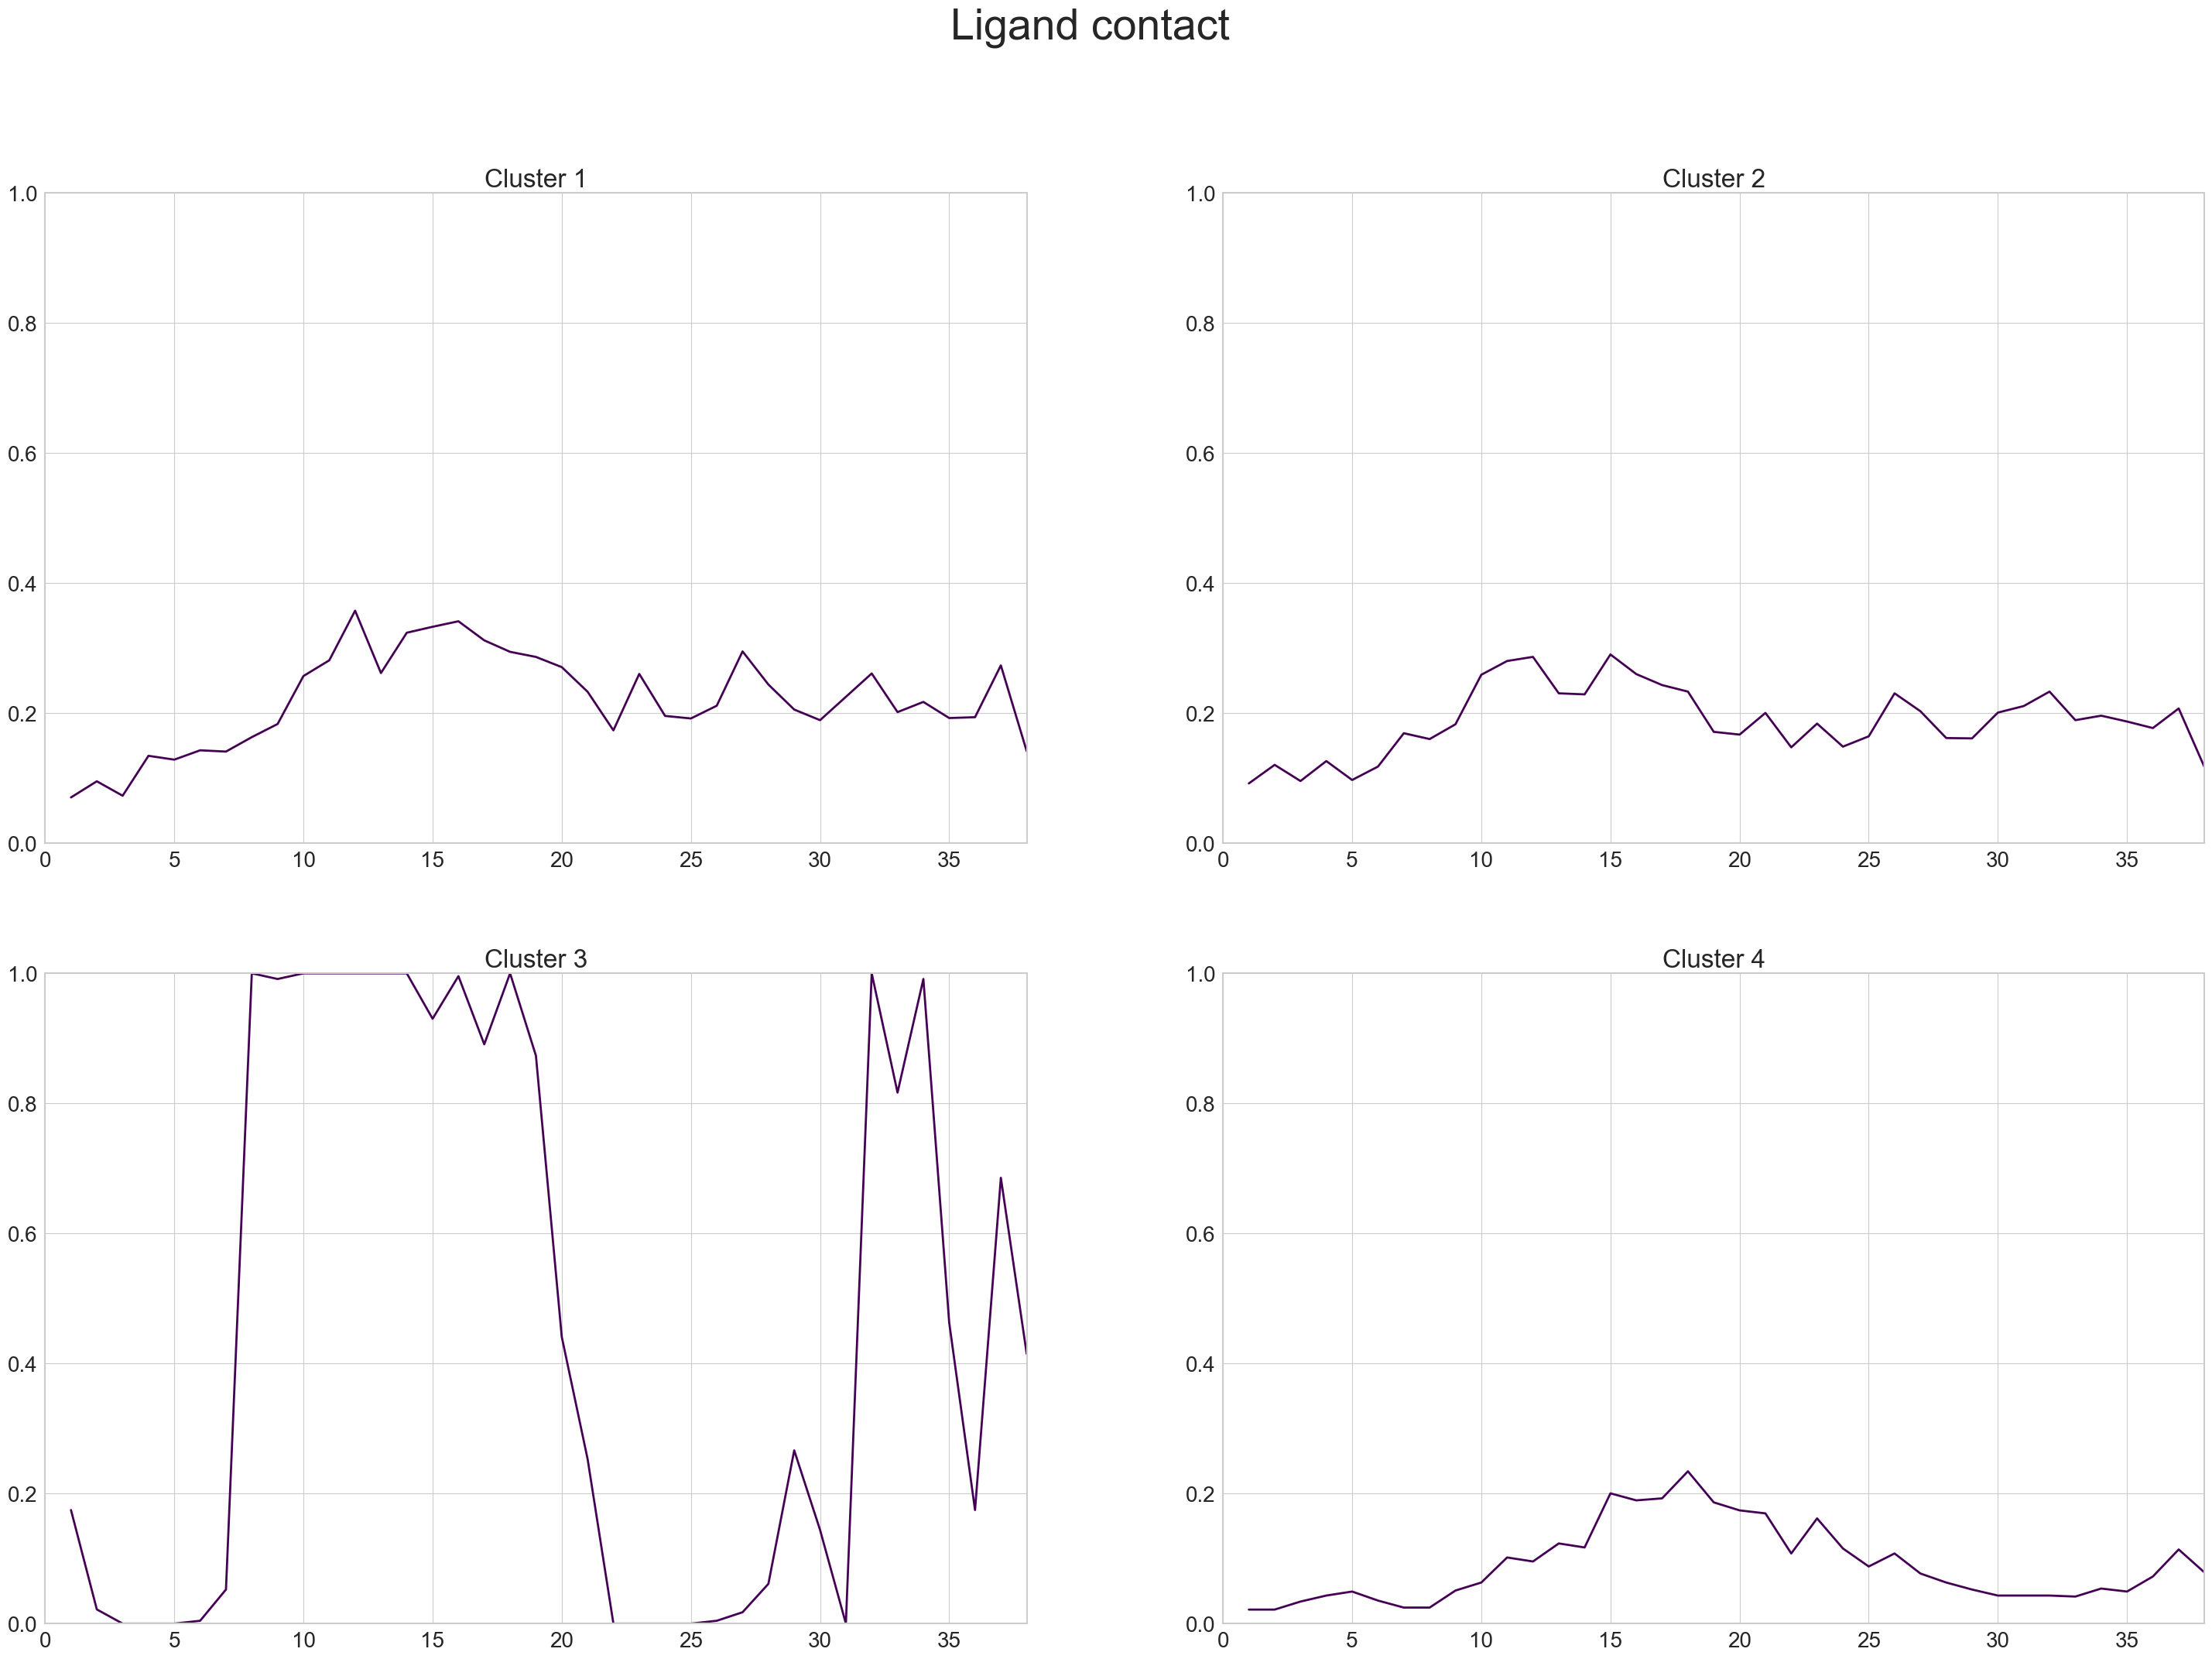

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(36, 24))

for i in range(0, 4):
    frame_ind = c_dict[i]
    ax[int(i/2), i % 2].plot(hres_renum[:-1], np.average(contact_array[frame_ind], axis=0))
    ax[int(i/2), i % 2].set_title('Cluster %s' % str(i+1), size=24)
    ax[int(i/2), i % 2].tick_params(axis='both', labelsize=20)
    ax[int(i/2), i % 2].set_xlim(0, 38)
    ax[int(i/2), i % 2].set_ylim(0, 1.0)
fig.suptitle('Ligand contact', size = 40)

Text(0.5, 0.98, 'Ligand interaction')

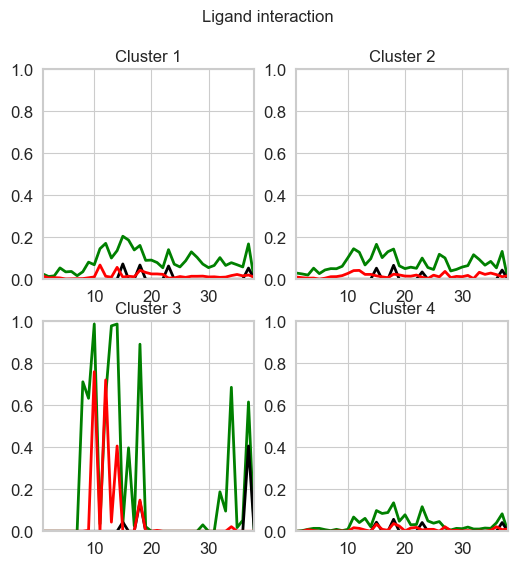

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i in range(0, n_cluster):
    frame_ind = c_dict[i]
    ax[int(i/2), i % 2].plot(hres_renum[:-1], np.average(hphob_array[frame_ind], axis=0), color = 'green')
    ax[int(i/2), i % 2].plot(hres_renum[:-1], np.average(aromatic_array[frame_ind], axis=0), color = 'black')
    ax[int(i/2), i % 2].plot(hres_renum[:-1], np.average(hbond_array[frame_ind], axis=0), color = 'red')    
    ax[int(i/2), i % 2].set_title('Cluster %s' % str(i+1), size=12)
    ax[int(i/2), i % 2].tick_params(axis='both', labelsize=12)
    ax[int(i/2), i % 2].set_xlim(1, 38)
    ax[int(i/2), i % 2].set_ylim(0, 1.0)
fig.suptitle('Ligand interaction', size = 12)

In [ ]:
population = [c_dict[i].size for i in c_dict.keys()]
population = np.array(population)/sum(population)

Text(0.5, 0.98, 'backbone interaction')

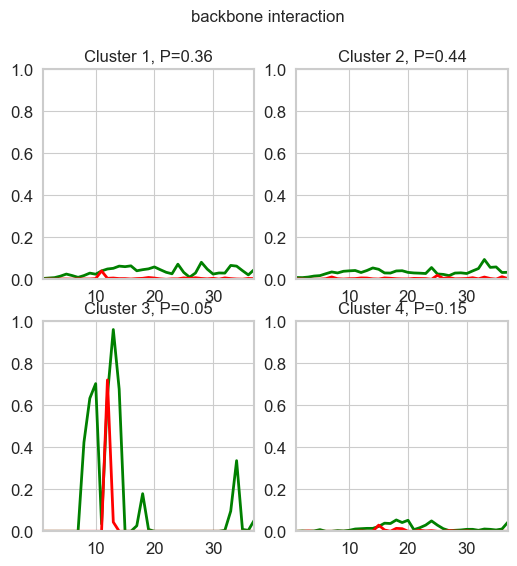

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for i in range(0, n_cluster):
    frame_ind = c_dict[i]
    ax[int(i/2), i % 2].plot(hres_renum[:-2], np.average(hphob_array_bb[frame_ind], axis=0), color = 'green')
    ax[int(i/2), i % 2].plot(hres_renum[:-2], np.average(hbond_array_bb[frame_ind], axis=0), color = 'red')    
    ax[int(i/2), i % 2].set_title('Cluster ' + str(i+1) + ", P=" + str(np.round(population[i],2)), size=12)
    ax[int(i/2), i % 2].tick_params(axis='both', labelsize=12)
    ax[int(i/2), i % 2].set_xlim(1, 37)
    ax[int(i/2), i % 2].set_ylim(0, 1.0)
fig.suptitle('backbone interaction', size = 12)

Text(0.5, 1.0, 'Average Backbone Interaction')

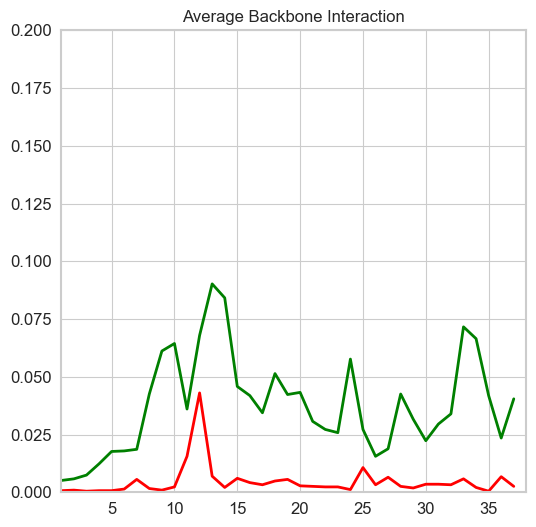

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))
plt.plot(hres_renum[:-2], np.average(hphob_array_bb, axis=0), color = 'green')
plt.plot(hres_renum[:-2], np.average(hbond_array_bb, axis=0), color = 'red')  
plt.xlim(1, 38)
plt.ylim(0, 0.2)
plt.title("Average Backbone Interaction")


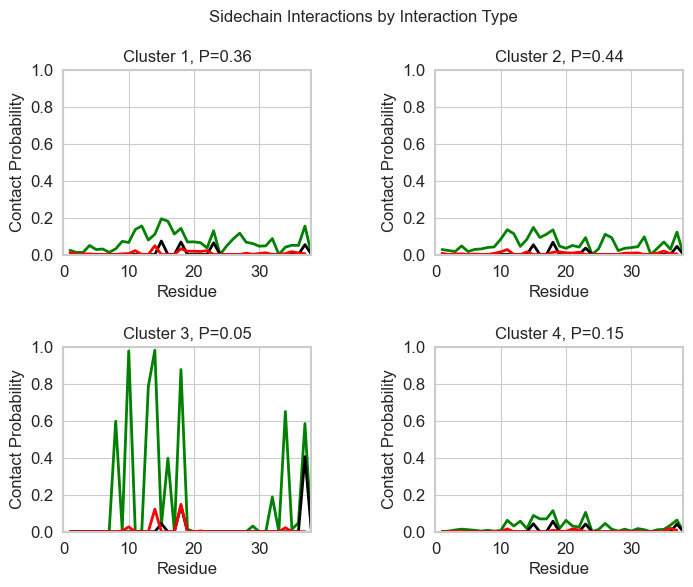

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

for i in range(0, n_cluster):
    frame_ind = c_dict[i]
    ax[int(i/2), i % 2].plot(hres_renum[:-1], np.average(hphob_array_sc[frame_ind], axis=0), color = 'green')
    ax[int(i/2), i % 2].plot(hres_renum[:-1], np.average(aromatic_array[frame_ind], axis=0), color = 'black')
    ax[int(i/2), i % 2].plot(hres_renum[:-2], np.average(hbond_array_sc[frame_ind], axis=0), color = 'red')    
    ax[int(i/2), i % 2].set_title('Cluster ' + str(i+1) + ", P=" + str(np.round(population[i],2)), size=12)
    ax[int(i/2), i % 2].tick_params(axis='both', labelsize=12)
    ax[int(i/2), i % 2].set_xlim(0, 38)
    ax[int(i/2), i % 2].set_ylim(0, 1.0)
    ax[int(i/2), i % 2].set_ylabel("Contact Probability")
    ax[int(i/2), i % 2].set_xlabel("Residue")
fig.suptitle('Sidechain Interactions by Interaction Type', size = 12)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.savefig(outdir + "wt_yxi1_ct_all_clusters_kd_contact_probability_by_interaction_type_sidechains.png", dpi=400, bbox_inches="tight")

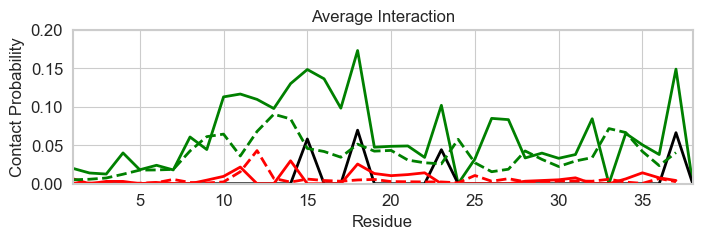

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,2))
plt.plot(hres_renum[:-1], np.average(hphob_array_sc, axis=0), color = 'green')
plt.plot(hres_renum[:-1], np.average(aromatic_array, axis=0), color = 'k')
plt.plot(hres_renum[:-2], np.average(hbond_array_sc, axis=0), color = 'red')  

plt.plot(hres_renum[:-2], np.average(hphob_array_bb, axis=0), color = 'green', linestyle="--")
plt.plot(hres_renum[:-2], np.average(hbond_array_bb, axis=0), color = 'red',linestyle="--")  

plt.xlim(1, 38)
plt.ylim(0, 0.2)
plt.xlabel("Residue")
plt.ylabel("Contact Probability")
plt.title("Average Interaction")
plt.savefig(outdir + "wt_yxi1_ct_average_contact_probability_by_interaction_type_sidechains.png", dpi=400, bbox_inches="tight")

In [ ]:
# 0, 1, 2, 3, 4, 5, 6, 7 all have some sort of entry equivalent 
# the fraction of values in diagonal
fraction_assignments = []
# n_cluster=4
for i in range(n_cluster): #enumerate(axes.flat):
    fraction_assignment = []
    # index data for this cluster 
    tensor = circuit_matrix[c_dict[i],:,:]
    # find the pairs 
    tensor_shape = tensor.shape 
    upper_triangle_indices = np.triu_indices(tensor_shape[1], k=1)

    # Broadcast the indices across the first axis
    broadcasted_indices = (
        np.arange(tensor_shape[0])[:, np.newaxis, np.newaxis],
        upper_triangle_indices[0],
        upper_triangle_indices[1]
    )

    # Use the broadcasted indices to access the values in the upper triangle
    values_in_upper_triangle = tensor[broadcasted_indices]
    for i in range(1,8): 
        fraction_assignment.append(np.where(values_in_upper_triangle == i)[0].size/ (np.where(values_in_upper_triangle != 0)[0].size)) # zero assignment not a contact
    print(np.sum(fraction_assignment))
    fraction_assignments.append(fraction_assignment)

1.0
1.0000000000000002
1.0
0.9999999999999998


([<matplotlib.axis.XTick at 0x1560765e0>,
 [Text(0.5, 0, 'Series'),
  Text(1.5, 0, 'Parallel'),
  Text(2.5, 0, 'Parallel-1'),
  Text(3.5, 0, 'Cross'),
  Text(4.5, 0, 'C. Parallel'),
  Text(5.5, 0, 'C. Parallel-1'),
  Text(6.5, 0, 'C. Series')])

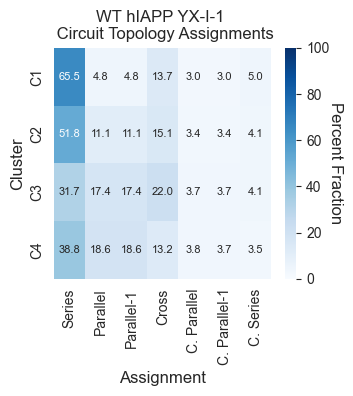

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,3))
heatmap = sns.heatmap(np.array(fraction_assignments)*100, cmap="Blues", annot=True, fmt="0.1f", ax=ax, annot_kws={"size": 8}, vmin=0.0, vmax=100.0)
# Customize colorbar tick sizes
cbar = heatmap.collections[0].colorbar  # Get the colorbar object
cbar.ax.tick_params(labelsize=10)  # Set the tick size
cbar.set_label("Percent Fraction", rotation=-90, labelpad=10)
# other details 
plt.title("WT hIAPP YX-I-1 \n Circuit Topology Assignments")
plt.xlabel("Assignment")
plt.ylabel("Cluster") 
plt.yticks(np.arange(n_cluster) + 0.5, labels=["C" + str(i+1) for i in range(n_cluster)], fontsize=10)
plt.xticks(np.arange(0,7) +0.5, labels=["Series", "Parallel", "Parallel-1", "Cross", 
                                 "C. Parallel", "C. Parallel-1", "C. Series"], rotation=90, fontsize=10) # 7 total assignments
# plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/wt_iapp_apo_circuit_top_matrix.png", dpi=300, bbox_inches="tight")
# plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/wt_iapp_apo_circuit_top_matrix.svg", dpi=300, bbox_inches="tight")

In [ ]:
# compute the matrix for the total
fraction_assignments = []
tensor = circuit_matrix 
# find the pairs 
tensor_shape = tensor.shape 
upper_triangle_indices = np.triu_indices(tensor_shape[1], k=1)

print(upper_triangle_indices)

# Broadcast the indices across the first axis
broadcasted_indices = (
    np.arange(tensor_shape[0])[:, np.newaxis, np.newaxis],
    upper_triangle_indices[0],
    upper_triangle_indices[1]
)

# Use the broadcasted indices to access the values in the upper triangle
values_in_upper_triangle = tensor[broadcasted_indices]
for i in range(1,8): 
    fraction_assignments.append(np.where(values_in_upper_triangle == i)[0].size/ (np.where(values_in_upper_triangle != 0)[0].size)) # zero assignment not a contact
print(np.sum(fraction_assignments))
fraction_assignments = [fraction_assignments]

(array([  0,   0,   0, ..., 663, 663, 664]), array([  1,   2,   3, ..., 664, 665, 665]))


(4301, 1, 221445)

([<matplotlib.axis.XTick at 0x150428280>,
 [Text(0.5, 0, 'Series'),
  Text(1.5, 0, 'Parallel'),
  Text(2.5, 0, 'Parallel-1'),
  Text(3.5, 0, 'Cross'),
  Text(4.5, 0, 'C. Parallel'),
  Text(5.5, 0, 'C. Parallel-1'),
  Text(6.5, 0, 'C. Series')])

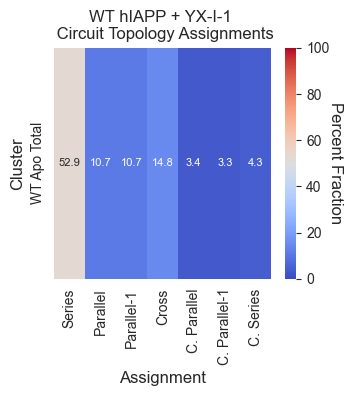

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,3))
heatmap = sns.heatmap(np.array(fraction_assignments)*100, cmap="coolwarm", annot=True, fmt="0.1f", ax=ax, annot_kws={"size": 8}, vmin=0.0, vmax=100.0)
# Customize colorbar tick sizes
cbar = heatmap.collections[0].colorbar  # Get the colorbar object
cbar.ax.tick_params(labelsize=10)  # Set the tick size
cbar.set_label("Percent Fraction", rotation=-90, labelpad=10)
# other details 
plt.title("WT hIAPP + YX-I-1 \n Circuit Topology Assignments")
plt.xlabel("Assignment")
plt.ylabel("Cluster") 
plt.yticks([0.5], labels=["WT Apo Total"], fontsize=10)
plt.xticks(np.arange(7) +0.5, labels=[ "Series", "Parallel", "Parallel-1", "Cross", 
                                 "C. Parallel", "C. Parallel-1", "C. Series"], rotation=90, fontsize=10) # 7 total assignments
# plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/wt_iapp_apo_circuit_top_matrix_overall.png", dpi=300, bbox_inches="tight")
# plt.savefig("../IAPP_compare_circuit_top_tsne/outdir_compare_circuit_top_tsne/wt_iapp_apo_circuit_top_matrix_overall.svg", dpi=300, bbox_inches="tight")

In [ ]:
np.save(outdir+psystem+"_ct_assignments_total_" + ".npy", np.array(fraction_assignments)*100)

In [ ]:
set(kmean_labels)

{0, 1, 2, 3}

Save the trajectory for visualization

In [ ]:
# # save the trajectory for visualization 
# for label in range(len(c_dict.keys())): 
#     temptrj = trj.slice(c_dict[label])
#     temptrj.save_dcd(traj_dir + "circuit_top_wt_iapp_yxi1_cutoff10_cluster_of_4_" + str(label+1)+ str(".dcd"))

Since most of the matrix is a sparse matrix, I want to know if we can actually encode the dual contact maps as a model input and then use the circuit topology relations as a fraction at the end. 

In [ ]:
def make_dual_contact_map_and_model(trj, prot_len=38, ligand_idx = 38):
    dim = int((prot_len)*(prot_len - 1)/2)
    model_input = np.zeros(shape=(dim, trj.n_frames))
    contacts = np.zeros(shape=(prot_len,prot_len,trj.n_frames))
    contact_avg = np.zeros(shape=(prot_len,prot_len))

    count=0
    for i in range(0, prot_len):
        contact_map = []
        # do not double compute 
        for j in range(i+1, prot_len):
            # compute the distance of the first and second ligand 
            dist1 = md.compute_contacts(trj, [[i, ligand_idx]], scheme='closest-heavy')
            dist2 = md.compute_contacts(trj, [[j, ligand_idx]], scheme='closest-heavy')

            # make those distances into arrays 
            array1 = np.asarray(dist1[0]).astype(float)
            array2 = np.asarray(dist2[0]).astype(float)

            # one-hot encode a contact if its within 0 and 1
            contact1 = np.where(array1 < 1.0, 1, 0)
            contact2 = np.where(array2 < 1.0, 1, 0)

            # sum the contacts and if there is a contact 
            # for both residues then we can one-hot encode a dual contact 
            sum = contact1 + contact2
            contact = np.where(sum == 2, 1, 0)
            contacts[i][j] = contact.reshape(trj.n_frames,)
            contacts[j][i] = contacts[i][j]

            contact_avg[i][j] = np.average(contacts[i][j])
            contact_avg[j][i] = contact_avg[i][j]

            model_input[count] = contacts[i][j]
            count += 1
    # transpose
    model_input = np.transpose(model_input)
    return model_input, contacts, contact_avg

In [ ]:
model_input, dc_contacts, dc_contact_avg = make_dual_contact_map_and_model(trj)

In [ ]:
# (n_frames, 1, pairs upper triangle vals)
# values_in_upper_triangle
n_frames, _, values = values_in_upper_triangle.shape
reshaped_array = values_in_upper_triangle.reshape((n_frames,values))

# count how many of each in each frame to find the max... 
max_vals = []
for i in range(1,8): 
    # Count the occurrences of the value
    counts = np.sum(reshaped_array == i, axis=1)
    max_vals.append(np.max(counts))

In [ ]:
normalized_topology = []
for i in range(1,8): 
    # Count the occurrences of the value for all frames and normalize
    counts = np.sum(reshaped_array == i, axis=1)/max_vals[i-1]
    normalized_topology.append(counts)

In [ ]:
normalized_topology_arr = np.array(normalized_topology)
normalized_topology_arr.size

30107

In [ ]:
model_dc_top = np.concatenate((model_input, normalized_topology_arr.T), axis=1)

In [ ]:
def make_contact_map(trj, res_num):
    """
    All elements to create a contact map one-hot encoded 
    :trj: (mdtraj object) trajectory 
    :res_num: (int) the number of residues 
    returns: (np.array) model input for PCA, contact average, and total contacts 
    """
    contacts = np.zeros(shape=(res_num,res_num,trj.n_frames))
    contact_avg = np.zeros(shape=(res_num,res_num))
    
    dim = int((res_num)*(res_num - 1)/2)
    model_input = np.zeros(shape=(dim, trj.n_frames))
    
    count = 0 
    for i in range(0, res_num):
        for j in range(i+1, res_num):
            contacts[i][j] = np.where(md.compute_contacts(trj,[[i,j]])[0] < 0.5, 1, 0).reshape(trj.n_frames,)
            contacts[j][i] = contacts[i][j]
             
            contact_avg[i][j] = np.average(contacts[i][j])
            contact_avg[j][i] = contact_avg[i][j] 
            
            model_input[count] = contacts[i][j]
            count += 1
    
    # transpose
    model_input = np.transpose(model_input)
    return model_input, contacts, contact_avg

In [ ]:
c_model_input, c_contacts, c_contact_avg = make_contact_map(trj,38)

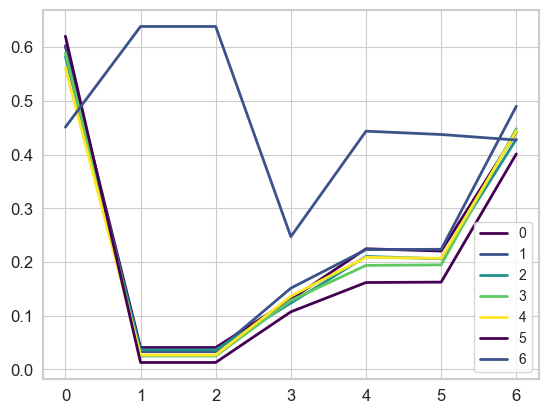

In [ ]:
for i in range(0,7):
    plt.plot(normalized_topology_arr[:,i], label=str(i))
plt.legend()
plt.show()

In [ ]:
model_c_top = np.concatenate((c_model_input, normalized_topology_arr.T), axis=1)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(model_c_top)
scaled_model = scaler.transform(model_c_top)

# without scaling 
pca = PCA(n_components=2)
pca.fit(scaled_model)
# scaling the model to see if that changes things! 
reduced = pca.fit_transform(scaled_model)
PC1 = reduced[:, 0]
PC2 = reduced[:, 1]

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_2881/67641934.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cdict = cm.get_cmap("nipy_spectral")._segmentdata


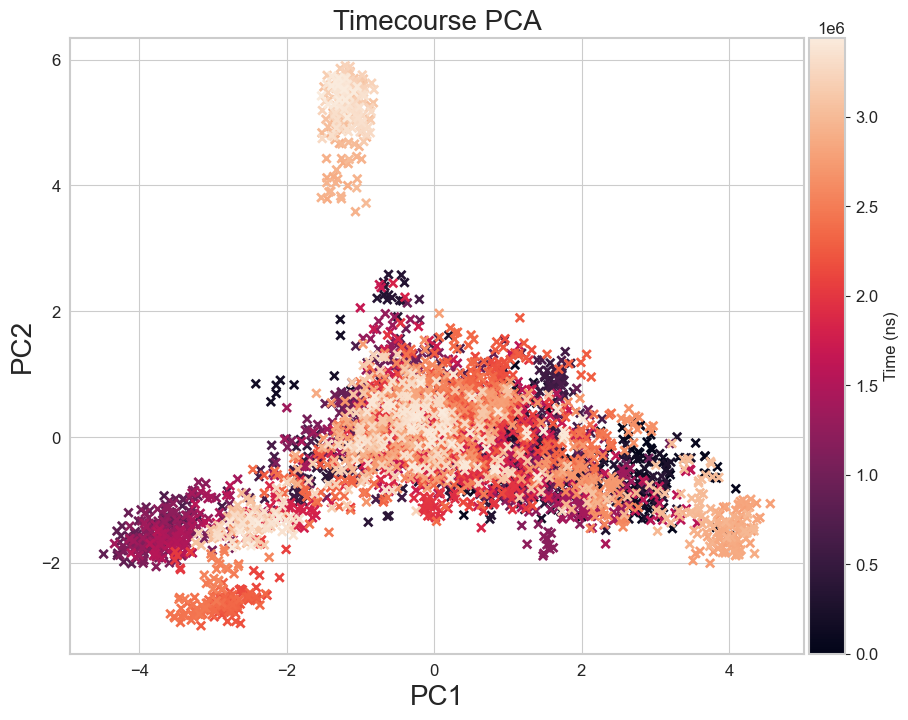

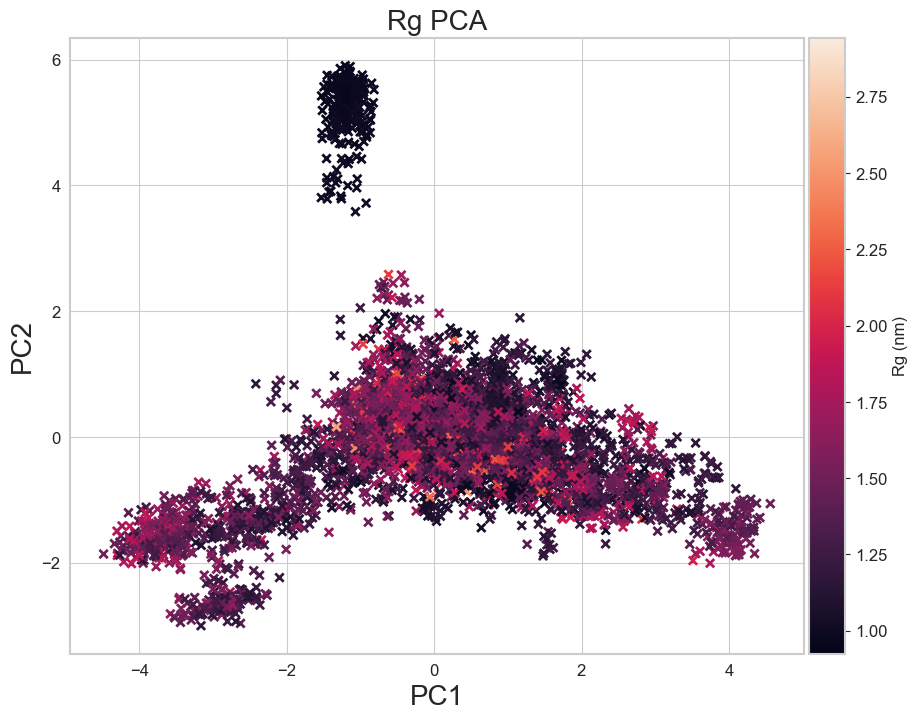

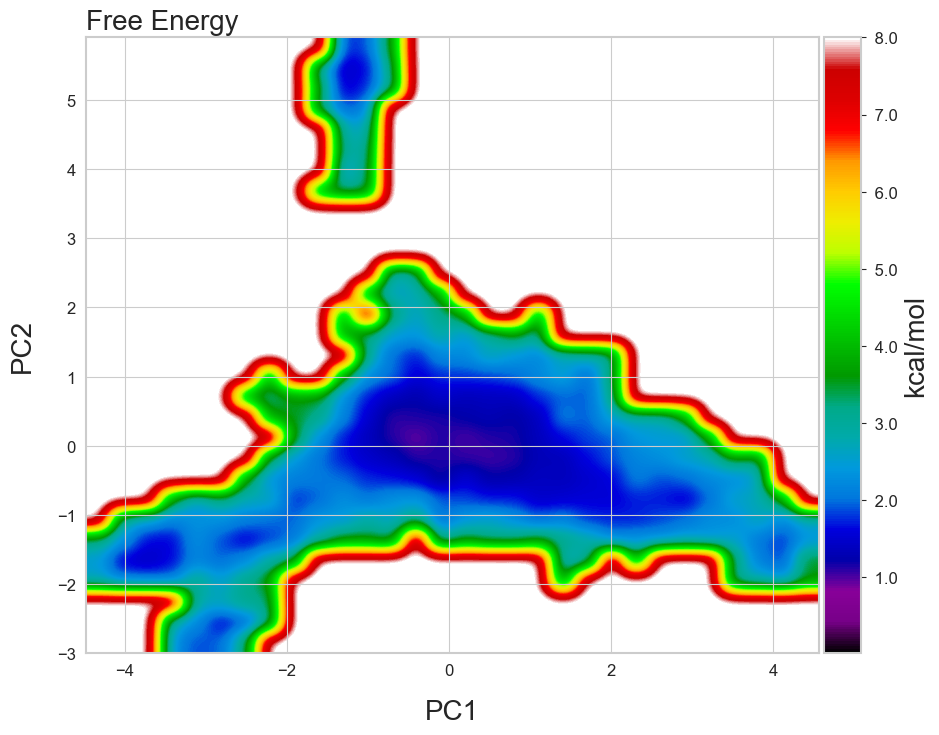

In [ ]:
# make a new color map 
cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)
ax1 = plt_project_time(PC1, PC2, trj.n_frames, time=trj.time[-1])
ax2 = plt_project_rg(PC1, PC2, trj)
ax3 = plt_free_energy(PC1, PC2, col_map= n_cmap, title="Free Energy" ) 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(c_model_input)
scaled_model = scaler.transform(c_model_input)

# without scaling 
pca = PCA(n_components=2)
pca.fit(scaled_model)
# scaling the model to see if that changes things! 
reduced = pca.fit_transform(scaled_model)
PC1 = reduced[:, 0]
PC2 = reduced[:, 1]

/var/folders/dm/wwztwm7s07d_s0pbc4_c0y_c0000gn/T/ipykernel_2881/67641934.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cdict = cm.get_cmap("nipy_spectral")._segmentdata


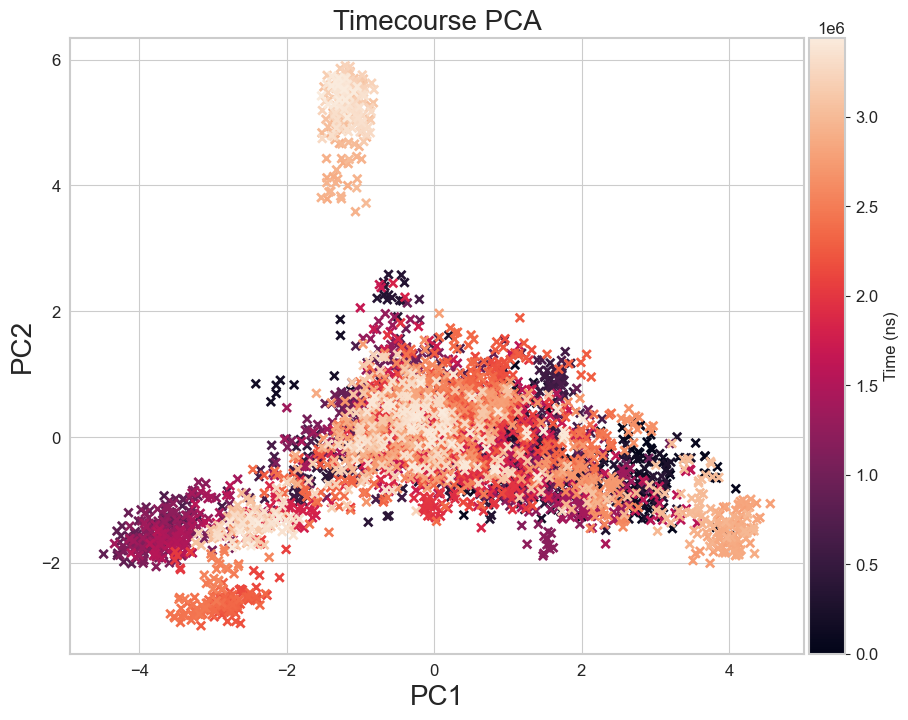

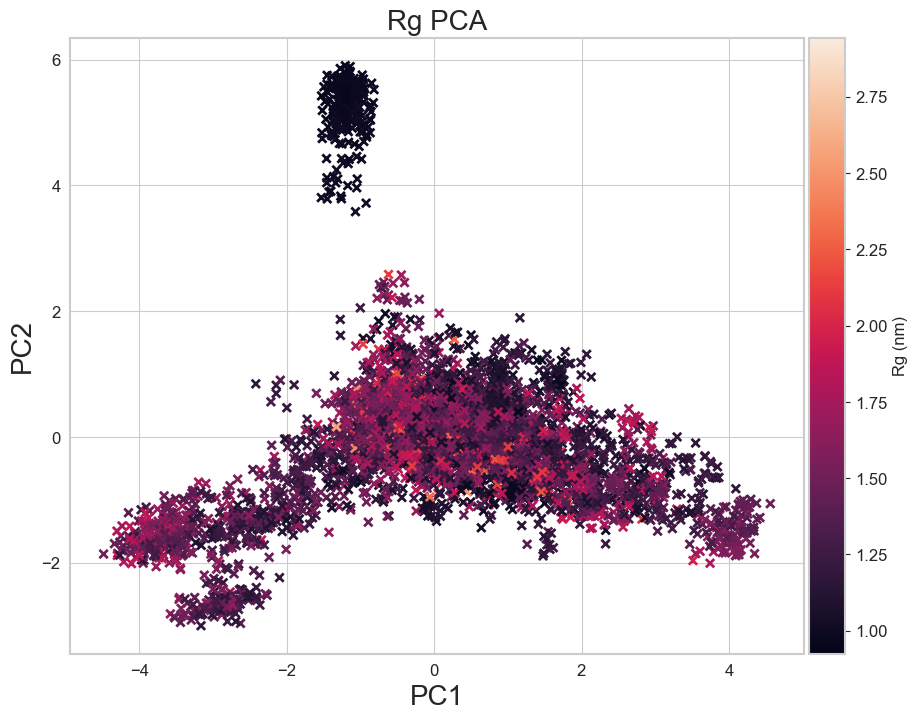

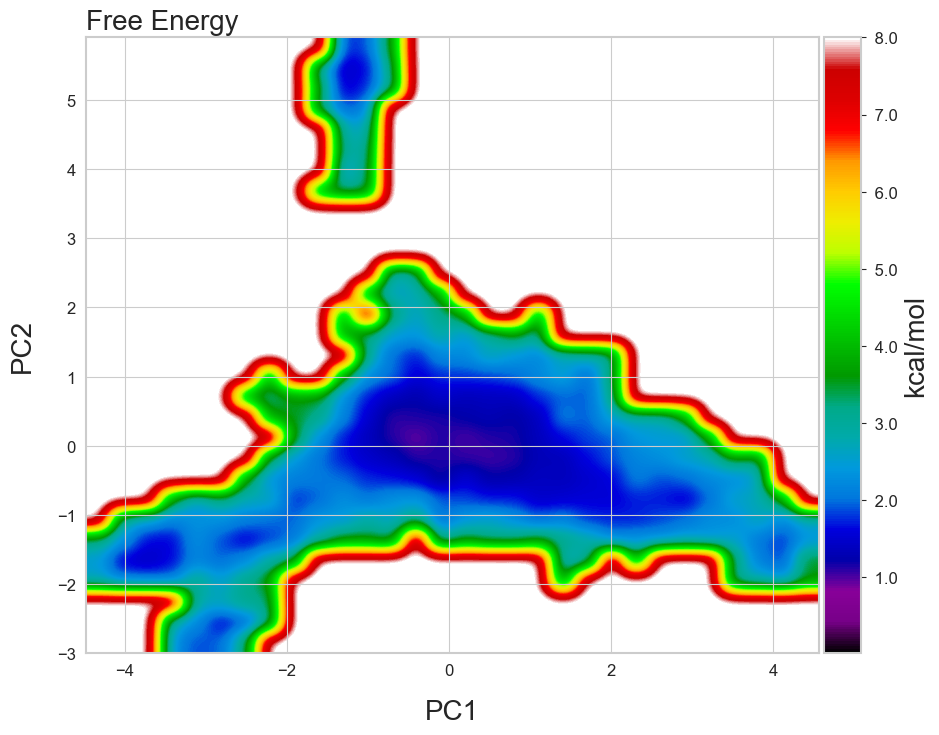

In [ ]:
# make a new color map 
cdict = cm.get_cmap("nipy_spectral")._segmentdata
cdict["red"][-1]=(1,1,1)
cdict["green"][-1]=(1,1,1)
cdict["blue"][-1]=(1,1,1)
n_cmap = colors.LinearSegmentedColormap("new_cmap", cdict)
ax1 = plt_project_time(PC1, PC2, trj.n_frames, time=trj.time[-1])
ax2 = plt_project_rg(PC1, PC2, trj)
ax3 = plt_free_energy(PC1, PC2, col_map= n_cmap, title="Free Energy" ) 